In [1]:
!pip install numpy
!pip install torch
!pip install torchvision
!pip install matplotlib
!pip install wandb

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 90.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 86.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 54.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 10.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 41.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 18.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 94.5 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitl

In [2]:
!git clone https://github.com/OscarOvanger/GeoDecepticon.git

Cloning into 'GeoDecepticon'...
remote: Enumerating objects: 20028, done.
remote: Counting objects: 100% (182/182), done.
remote: Compressing objects: 100% (53/53), done.
remote: Total 20028 (delta 157), reused 131 (delta 129), pack-reused 19846 (from 3)
Receiving objects: 100% (20028/20028), 107.62 MiB | 18.19 MiB/s, done.
Resolving deltas: 100% (435/435), done.
Updating files: 100% (79/79), done.


In [3]:
import os
os.chdir('/content/GeoDecepticon')

In [4]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
import wandb
import os
from tqdm.notebook import tqdm
import copy
from GeneralViT import VisionTransformer, create_model
from tqdm import tqdm  # For progress bars

# Load and plot training data

(9000, 60, 60)


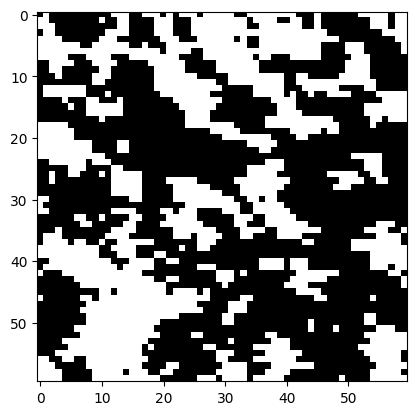

In [5]:
arr = np.load("Data/Markov_field/training_data.npz")["arr_0"]
training_data = arr[:9000]
test_data = arr[9000:]
# We reshape it to 60x60 dataset
training_data = training_data.reshape(-1, 64, 64)
test_data = test_data.reshape(-1, 64, 64)
training_data = training_data[:,:60,:60]
test_data = test_data[:,:60,:60]
print(training_data.shape)
training_data = torch.tensor(training_data,dtype=torch.float32)
test_data = torch.tensor(test_data,dtype=torch.float32)
#plot the first data
plt.imshow(training_data[0],cmap='gray')
plt.show()

# ChatGPT o3-mini-high approach

In [6]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import wandb
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt

########################################
# Helper: Convert Patches to Integer Code
########################################

def patch_to_int(patches):
    """
    Converts a tensor of patches (shape: [N, patch_dim]) containing binary values
    to an integer code. Assumes values are near 0 or 1.
    """
    patches_bin = patches.round().long()  # ensure binary
    patch_dim = patches_bin.shape[1]
    powers = (2 ** torch.arange(patch_dim - 1, -1, -1, device=patches.device)).unsqueeze(0)
    codes = (patches_bin * powers).sum(dim=1)
    return codes

########################################
# Helper: Image Sampling (Conditional)
########################################

def sample_image_conditional(model, patch_size, image_size, temperature=1.0,
                             condition_indices=None, condition_values=None):
    """
    Generate one image using the autoregressive model while enforcing conditions.
    Instead of a fixed raster-scan order, this function first generates the patches
    that contain condition values and then fills in the rest in order of increasing
    Manhattan distance from any conditioned patch.

    Returns:
      - generated: a tensor of shape (1, num_patches, patch_dim)
      - log_likelihood: the sum of log-probabilities for the sampled tokens.
    """
    num_patches = (image_size // patch_size) ** 2
    patch_dim = patch_size * patch_size
    grid_size = image_size // patch_size

    # Build patch-level conditions: a dictionary mapping patch index -> {local index: condition value}
    patch_conditions = {}
    if condition_indices is not None and condition_values is not None:
        for cond_idx, cond_val in zip(condition_indices, condition_values):
            global_row = int(cond_idx) // image_size
            global_col = int(cond_idx) % image_size
            patch_row = global_row // patch_size
            patch_col = global_col // patch_size
            patch_index = patch_row * grid_size + patch_col
            local_row = global_row % patch_size
            local_col = global_col % patch_size
            local_index = local_row * patch_size + local_col
            if patch_index not in patch_conditions:
                patch_conditions[patch_index] = {}
            patch_conditions[patch_index][local_index] = float(cond_val)

    # Define a helper to compute patch coordinates.
    def patch_coords(i):
        return (i // grid_size, i % grid_size)

    # Determine generation order.
    # First, the conditioned patch indices (those that appear in patch_conditions).
    conditioned_indices = set(patch_conditions.keys())
    conditioned_list = sorted(list(conditioned_indices))

    # Then, the remaining indices sorted by minimum Manhattan distance to any conditioned patch.
    remaining = [i for i in range(num_patches) if i not in conditioned_indices]
    def min_distance(i):
        r_i, c_i = patch_coords(i)
        # If no conditioned patch, return a high number.
        return min(abs(r_i - patch_coords(j)[0]) + abs(c_i - patch_coords(j)[1])
                   for j in conditioned_indices) if conditioned_indices else 0
    remaining = sorted(remaining, key=min_distance)

    # Final generation order: first fill in conditioned patches, then the rest.
    order_list = conditioned_list + remaining

    # Initialize generated patches with the learnable mask token.
    generated = model.mask_token.detach().clone().unsqueeze(0).repeat(num_patches, 1)
    log_likelihood = 0.0
    # Add a batch dimension.
    generated = generated.unsqueeze(0)  # shape: (1, num_patches, patch_dim)

    # Generate patches in the determined order.
    for idx in order_list:
        # Optionally, if this patch has a condition, restrict candidates.
        cond = patch_conditions.get(idx, None)
        # Compute logits for the entire sequence.
        logits = model(generated)  # shape: (1, num_patches, vocab_size)
        logits_i = logits[0, idx] / temperature
        if cond is not None:
            candidate_mask = torch.ones(model.vocab_size, dtype=torch.bool, device=logits_i.device)
            for local_idx, cond_val in cond.items():
                candidate_mask = candidate_mask & (model.vocab[:, local_idx] == cond_val)
            logits_i = logits_i.masked_fill(~candidate_mask, -1e9)
        probs = torch.softmax(logits_i, dim=-1)
        token = torch.multinomial(probs, num_samples=1)
        log_prob = torch.log(probs[token] + 1e-10)
        log_likelihood += log_prob.item()
        patch = model.vocab[token]
        generated[0, idx] = patch

    return generated, log_likelihood

########################################
# Vision Transformer and Transformer Encoder Layer
########################################

class VisionTransformer(nn.Module):
    def __init__(self, num_heads, num_layers, ffn_dim, hidden_dim, dropout=0.0):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.transformer_layers = nn.ModuleList([
            TransformerEncoderLayer(hidden_dim, num_heads, ffn_dim, dropout)
            for _ in range(num_layers)
        ])
        self.dropout_layer = nn.Dropout(dropout)

    def build_vocabulary(self, training_data, patch_size, full_mask=True, one_mask=True):
        self.patch_size = patch_size
        patch_dim = patch_size * patch_size
        H, W = training_data.shape[1], training_data.shape[2]
        num_patches = (H // patch_size) * (W // patch_size)
        patches_tensor = training_data.unfold(1, patch_size, patch_size)\
                                        .unfold(2, patch_size, patch_size)
        patches_tensor = patches_tensor.contiguous().view(-1, patch_dim)
        unique_set = set()
        unique_list = []
        for patch in tqdm(patches_tensor, desc=f"Building Vocabulary for {patch_size}x{patch_size}", total=patches_tensor.shape[0]):
            patch_cpu = patch.cpu()
            patch_tuple = tuple(patch_cpu.tolist())
            if patch_tuple not in unique_set:
                unique_set.add(patch_tuple)
                unique_list.append(patch_cpu)
        if full_mask:
            unique_list.append(torch.full((patch_dim,), 0.5, dtype=torch.float, device='cpu'))
        if one_mask:
            for i in range(patch_dim):
                mask_patch = torch.full((patch_dim,), 0.5, dtype=torch.float, device='cpu')
                mask_patch[i] = 0.0
                unique_list.append(mask_patch)
                mask_patch = torch.full((patch_dim,), 0.5, dtype=torch.float, device='cpu')
                mask_patch[i] = 1.0
                unique_list.append(mask_patch)
        self.vocab = torch.stack(unique_list)
        self.vocab_size = self.vocab.size(0)
        self.vocab_int = patch_to_int(self.vocab)
        self.embedding_projection = nn.Linear(patch_dim, self.hidden_dim)
        self.output_projection = nn.Linear(self.hidden_dim, self.vocab_size)
        self.pos_embedding = nn.Parameter(torch.zeros(1, num_patches, self.hidden_dim))
        self.mask_token = nn.Parameter(torch.full((patch_dim,), 0.5, dtype=torch.float))
        return self.vocab

    def forward(self, patches):
        # patches: (B, num_patches, patch_dim)
        B, num_patches, _ = patches.shape
        embeddings = self.embedding_projection(patches)
        embeddings = embeddings + self.pos_embedding[:, :num_patches, :]
        z = self.dropout_layer(embeddings)
        for layer in self.transformer_layers:
            z = layer(z)
        logits = self.output_projection(z)  # (B, num_patches, vocab_size)
        return logits

class TransformerEncoderLayer(nn.Module):
    def __init__(self, hidden_dim, num_heads, ffn_dim, dropout=0.1):
        super().__init__()
        self.self_attn = nn.MultiheadAttention(hidden_dim, num_heads, dropout=dropout)
        self.linear1 = nn.Linear(hidden_dim, ffn_dim)
        self.linear2 = nn.Linear(ffn_dim, hidden_dim)
        self.norm1 = nn.LayerNorm(hidden_dim)
        self.norm2 = nn.LayerNorm(hidden_dim)
        self.dropout1 = nn.Dropout(dropout)
        self.dropout2 = nn.Dropout(dropout)
        self.activation = nn.GELU()

    def forward(self, z):
        z_norm = self.norm1(z)
        z_t = z_norm.transpose(0, 1)
        attn_output, _ = self.self_attn(z_t, z_t, z_t)
        attn_output = attn_output.transpose(0, 1)
        z = z + self.dropout1(attn_output)
        z_norm = self.norm2(z)
        ff_output = self.linear2(self.dropout2(self.activation(self.linear1(z_norm))))
        z = z + self.dropout2(ff_output)
        return z

########################################
# Dataset and Patch Extraction
########################################

class BinaryImageDataset(Dataset):
    def __init__(self, images):
        self.images = images  # shape: (N, H, W)
    def __len__(self):
        return len(self.images)
    def __getitem__(self, idx):
        return self.images[idx]
    @staticmethod
    def batch_to_patches(images, patch_size):
        B, H, W = images.shape
        patches = images.unfold(1, patch_size, patch_size).unfold(2, patch_size, patch_size)
        patches = patches.contiguous().view(B, -1, patch_size * patch_size)
        return patches
    @staticmethod
    def patches_to_image(patches, patch_size, image_size):
        # patches: (num_patches, patch_dim) ordered in raster scan.
        image = torch.zeros(image_size, image_size, device=patches.device)
        idx = 0
        for i in range(0, image_size, patch_size):
            for j in range(0, image_size, patch_size):
                image[i:i+patch_size, j:j+patch_size] = patches[idx].view(patch_size, patch_size)
                idx += 1
        return image

########################################
# Training Pipeline (Loss only on masked tokens)
########################################

def train_model_for_patch(patch_size, training_data, num_epochs=1000, batch_size=128):
    # Increased model capacity.
    num_heads = 8
    num_layers = 8
    ffn_dim = 1024
    hidden_dim = 256

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    training_data = training_data.to(device)
    image_size = training_data.shape[1]

    wandb.init(project="vision-transformer-comparison",
               config={
                   "num_heads": num_heads,
                   "num_layers": num_layers,
                   "ffn_dim": ffn_dim,
                   "hidden_dim": hidden_dim,
                   "patch_size": patch_size,
                   "num_epochs": num_epochs,
                   "batch_size": batch_size
               },
               name=f"patch_{patch_size}x{patch_size}",
               reinit=True)

    model = VisionTransformer(num_heads, num_layers, ffn_dim, hidden_dim, dropout=0.1)
    model.build_vocabulary(training_data, patch_size)
    model = model.to(device)
    model.vocab = model.vocab.to(device)
    model.vocab_int = patch_to_int(model.vocab).to(device)

    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.CrossEntropyLoss()

    dataset = BinaryImageDataset(training_data)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    for epoch in range(num_epochs):
        model.train()
        total_loss = 0.0
        # Gradual mask schedule.
        num_patches = (image_size // patch_size) ** 2
        min_mask_rate = 1.0 / num_patches
        base_mask_rate = min_mask_rate + (1.0 - min_mask_rate) * (epoch / num_epochs)
        mask_rate = np.clip(base_mask_rate + np.random.uniform(-0.1, 0.1), min_mask_rate, 1.0)
        partial_mask_rate = 0.3

        epoch_bar = tqdm(dataloader, desc=f"Epoch {epoch+1}/{num_epochs} (patch {patch_size}x{patch_size})", leave=False)
        for batch in epoch_bar:
            batch = batch.to(device)
            B = batch.shape[0]
            patches = BinaryImageDataset.batch_to_patches(batch, patch_size)  # (B, num_patches, patch_dim)
            patch_dim = patches.shape[2]

            # Create mask for each patch (only masked tokens contribute to loss).
            mask = torch.rand(B, num_patches, device=device) < mask_rate
            mask[:, 0] = True

            partial = (torch.rand(B, num_patches, device=device) < partial_mask_rate) & mask
            full = mask & (~partial)

            masked_patches = patches.clone()
            if full.any():
                masked_patches[full] = model.mask_token
            if partial.any():
                partial_idx = torch.nonzero(partial)
                num_partial = partial_idx.shape[0]
                new_patches = torch.full((num_partial, patch_dim), 0.5, device=device)
                rand_positions = torch.randint(0, patch_dim, (num_partial,), device=device)
                orig_vals = patches[partial_idx[:, 0], partial_idx[:, 1], :].gather(1, rand_positions.unsqueeze(1)).squeeze(1)
                new_patches[torch.arange(num_partial), rand_positions] = orig_vals
                masked_patches[partial_idx[:, 0], partial_idx[:, 1]] = new_patches

            # Forward pass.
            logits = model(masked_patches)  # (B, num_patches, vocab_size)

            # Compute targets over all patches.
            all_patches = patches.view(B * num_patches, patch_dim)
            codes = patch_to_int(all_patches)
            vocab_codes = model.vocab_int
            mask_eq = codes.unsqueeze(1) == vocab_codes.unsqueeze(0)
            target_indices = mask_eq.float().argmax(dim=1)
            targets_all = target_indices.view(B, num_patches)

            # Now compute loss only over masked tokens.
            if mask.sum() > 0:
                loss = criterion(logits[mask], targets_all[mask])
            else:
                loss = torch.tensor(0.0, device=device)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            epoch_bar.set_postfix(loss=loss.item(), mask_rate=mask_rate)
        avg_loss = total_loss / len(dataloader)
        wandb.log({"epoch": epoch, "loss": avg_loss, "mask_rate": mask_rate})
        print(f"[Patch {patch_size}x{patch_size}] Epoch {epoch+1}/{num_epochs}, Loss: {avg_loss:.4f}, Mask Rate: {mask_rate:.2f}")

        # --- Visualization on First Batch ---
        model.eval()
        with torch.no_grad():
            batch0 = next(iter(dataloader)).to(device)
            patches0 = BinaryImageDataset.batch_to_patches(batch0, patch_size)
            B0, num_patches, patch_dim = patches0.shape
            # Create visualization mask (same as training mask for this batch).
            vis_mask = (torch.rand(1, num_patches, device=device) < mask_rate).squeeze(0)
            vis_mask[0] = True  # ensure at least one mask.
            vis_partial = (torch.rand(1, num_patches, device=device) < partial_mask_rate).squeeze(0) & vis_mask
            vis_full = vis_mask & (~vis_partial)
            masked_vis = patches0[0].clone()
            if vis_full.any():
                masked_vis[vis_full] = model.mask_token
            if vis_partial.any():
                partial_idx_vis = torch.nonzero(vis_partial)
                num_partial_vis = partial_idx_vis.shape[0]
                new_patches_vis = torch.full((num_partial_vis, patch_dim), 0.5, device=device)
                rand_positions_vis = torch.randint(0, patch_dim, (num_partial_vis,), device=device)
                orig_vals_vis = patches0[0, partial_idx_vis[:, 0], :].gather(1, rand_positions_vis.unsqueeze(1)).squeeze(1)
                new_patches_vis[torch.arange(num_partial_vis), rand_positions_vis] = orig_vals_vis
                masked_vis[partial_idx_vis[:, 0]] = new_patches_vis
            # For visualization, reconstruct only the masked patches.
            logits_vis = model(masked_vis.unsqueeze(0))
            predicted_tokens = torch.argmax(logits_vis, dim=-1).squeeze(0)
            recon_vis = patches0[0].clone()  # start with original
            # Replace only masked positions with model's predictions.
            recon_vis[vis_mask] = model.vocab[predicted_tokens[vis_mask]]
            masked_img = BinaryImageDataset.patches_to_image(masked_vis, patch_size, image_size)
            recon_img = BinaryImageDataset.patches_to_image(recon_vis, patch_size, image_size)
            original_img = BinaryImageDataset.patches_to_image(patches0[0], patch_size, image_size)
            wandb.log({
                "original": wandb.Image(original_img.cpu()),
                "masked": wandb.Image(masked_img.cpu()),
                "reconstructed": wandb.Image(recon_img.cpu())
            })

        # --- Every 100 Epochs: Conditional Sampling ---
        if (epoch + 1) % 100 == 0:
            condition_indices = np.array([876,3825,2122,2892,1556,2683,3667,1767,483,2351,2000,3312,
                                          2953,289,2373,2720,872,2713,1206,1341,3541,2226,3423,1904,
                                          2882,2540,1497,2524,264,1441])
            condition_values = np.array([0,1,1,1,0,0,1,0,0,1,0,0,0,1,0,1,0,0,1,0,1,1,1,0,1,0,1,1,0,1])
            gen, ll = sample_image_conditional(model, patch_size, image_size, temperature=1.0,
                                               condition_indices=condition_indices,
                                               condition_values=condition_values)
            gen_img = BinaryImageDataset.patches_to_image(gen[0], patch_size, image_size)
            wandb.log({"conditional_sample": wandb.Image(gen_img.cpu(), caption=f"LL: {ll:.2f}")})

        if (epoch + 1) % 100 == 0:
            torch.save(model.state_dict(), f"vision_transformer_patch{patch_size}x{patch_size}_epoch{epoch+1}.pth")
    wandb.finish()
    return model

########################################
# Main: Train the Model
########################################
'''
if __name__ == "__main__":
    arr = np.load("Data/Markov_field/training_data.npz")["arr_0"]
    training_data = arr[:9000]
    training_data = training_data.reshape(-1, 64, 64)  # 60x60 images; adjust if needed.
    print("Training data shape:", training_data.shape)
    training_data = torch.tensor(training_data, dtype=torch.float32)
    patch_size = 4
    model = train_model_for_patch(patch_size, training_data)
'''

'\nif __name__ == "__main__":\n    arr = np.load("Data/Markov_field/training_data.npz")["arr_0"]\n    training_data = arr[:9000]\n    training_data = training_data.reshape(-1, 64, 64)  # 60x60 images; adjust if needed.\n    print("Training data shape:", training_data.shape)\n    training_data = torch.tensor(training_data, dtype=torch.float32)\n    patch_size = 4\n    model = train_model_for_patch(patch_size, training_data)\n'

In [7]:
os.chdir('..')

Training data shape: (9000, 64, 64)


Building Vocabulary for 4x4: 100%|██████████| 2304000/2304000 [00:09<00:00, 232236.39it/s]


Loading checkpoint: vision_transformer_patch4x4_epoch300 (1).pth


<ipython-input-9-61962f782dc3>:61: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(ckpt_path, map_location=device)


Saved 1000 samples for epoch 300.


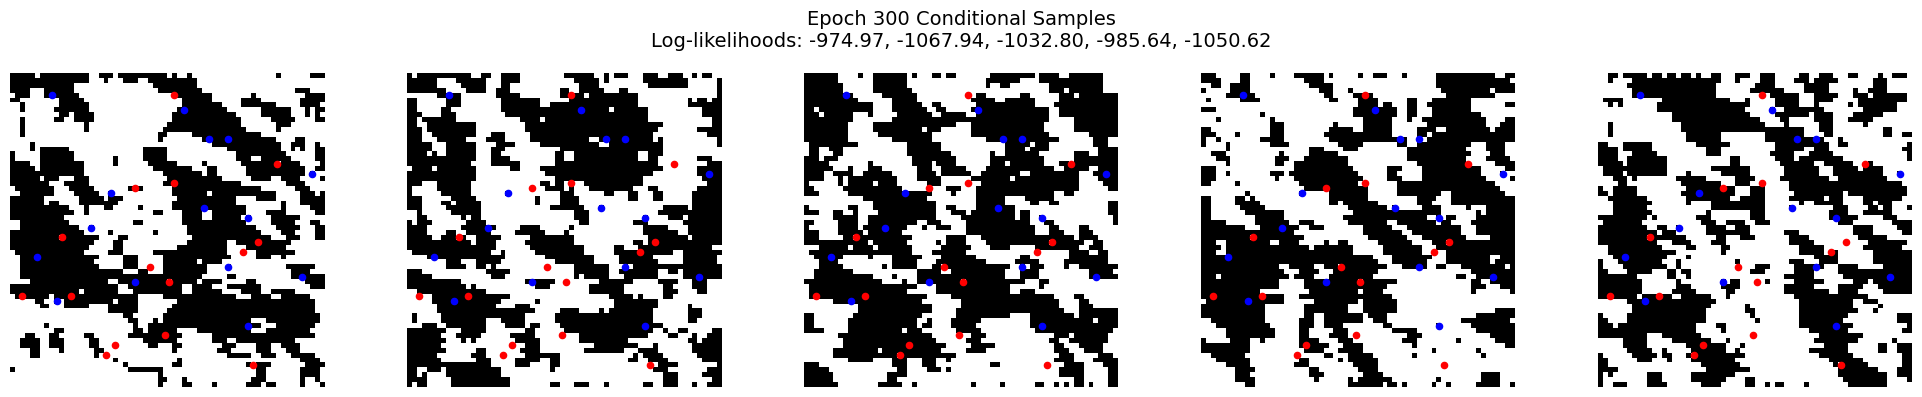

Loading checkpoint: vision_transformer_patch4x4_epoch400 (1).pth
Saved 1000 samples for epoch 400.


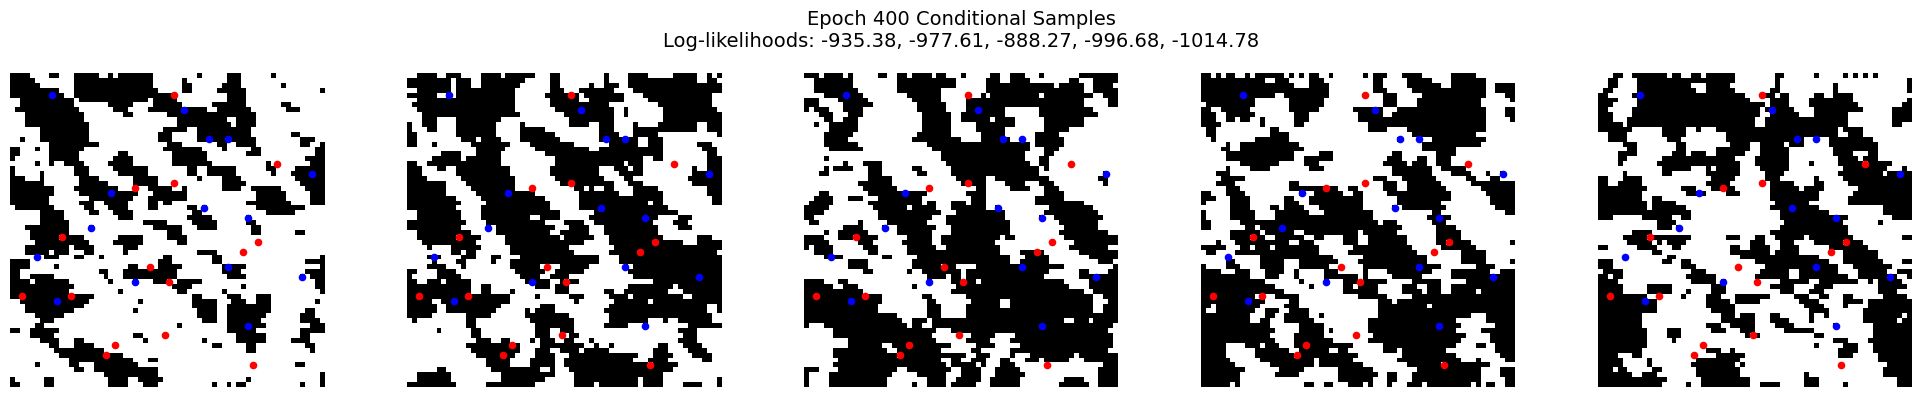

Loading checkpoint: vision_transformer_patch4x4_epoch500 (1).pth
Saved 1000 samples for epoch 500.


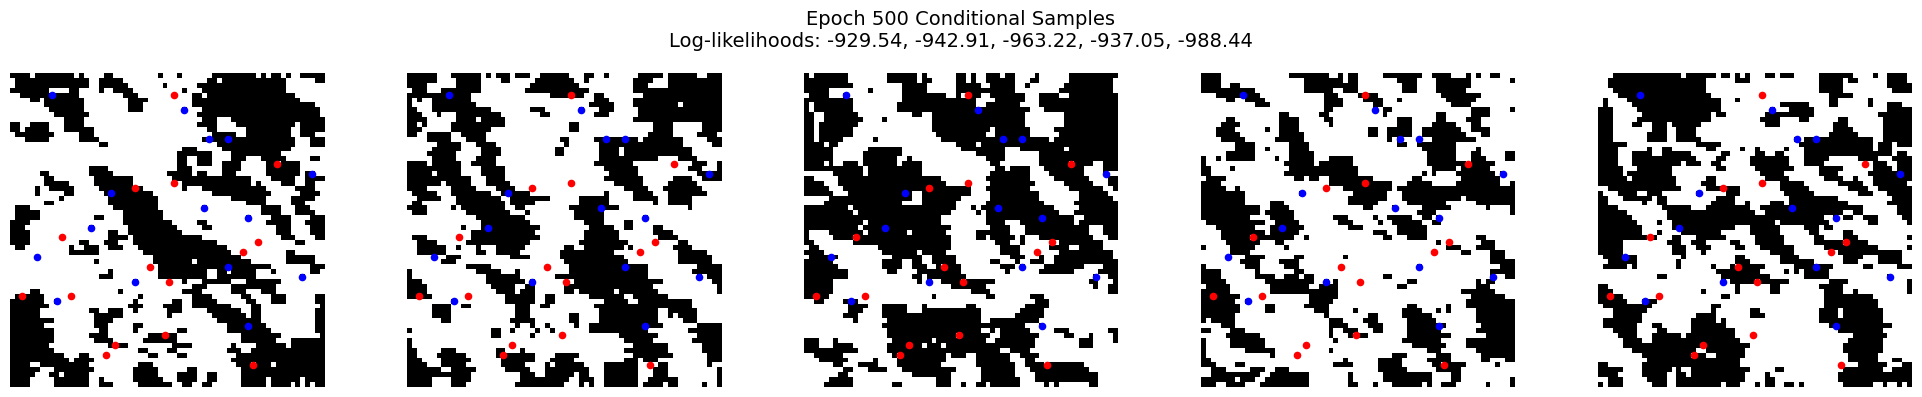

Loading checkpoint: vision_transformer_patch4x4_epoch600 (1).pth
Saved 1000 samples for epoch 600.


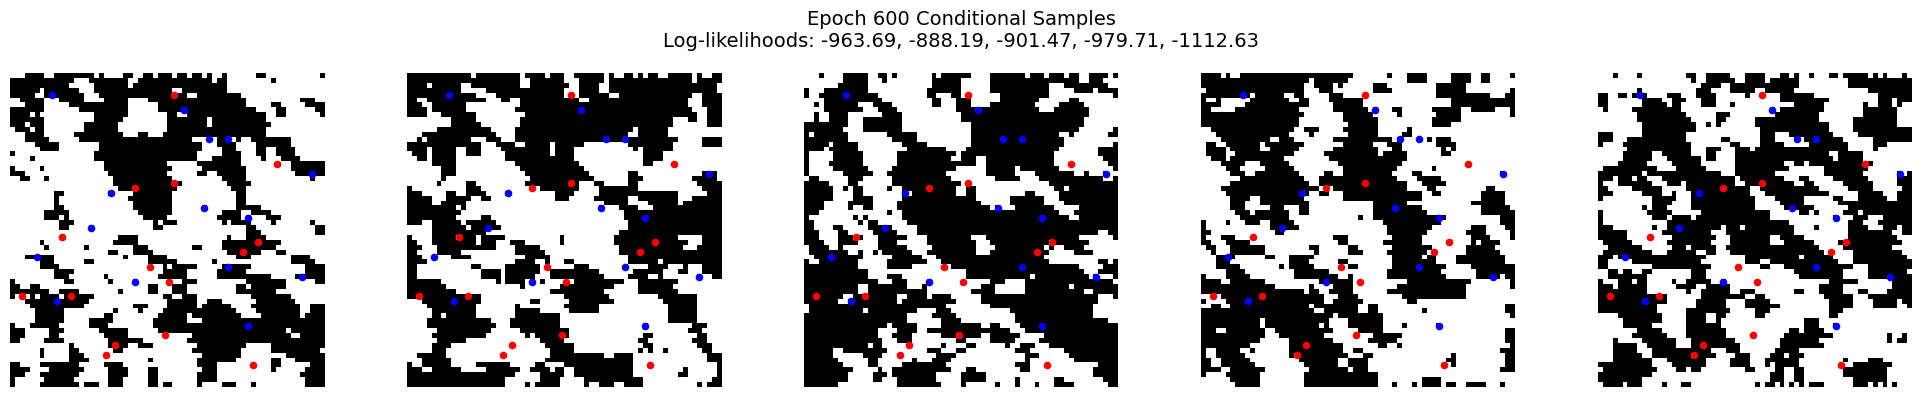

Loading checkpoint: vision_transformer_patch4x4_epoch700 (1).pth
Saved 1000 samples for epoch 700.


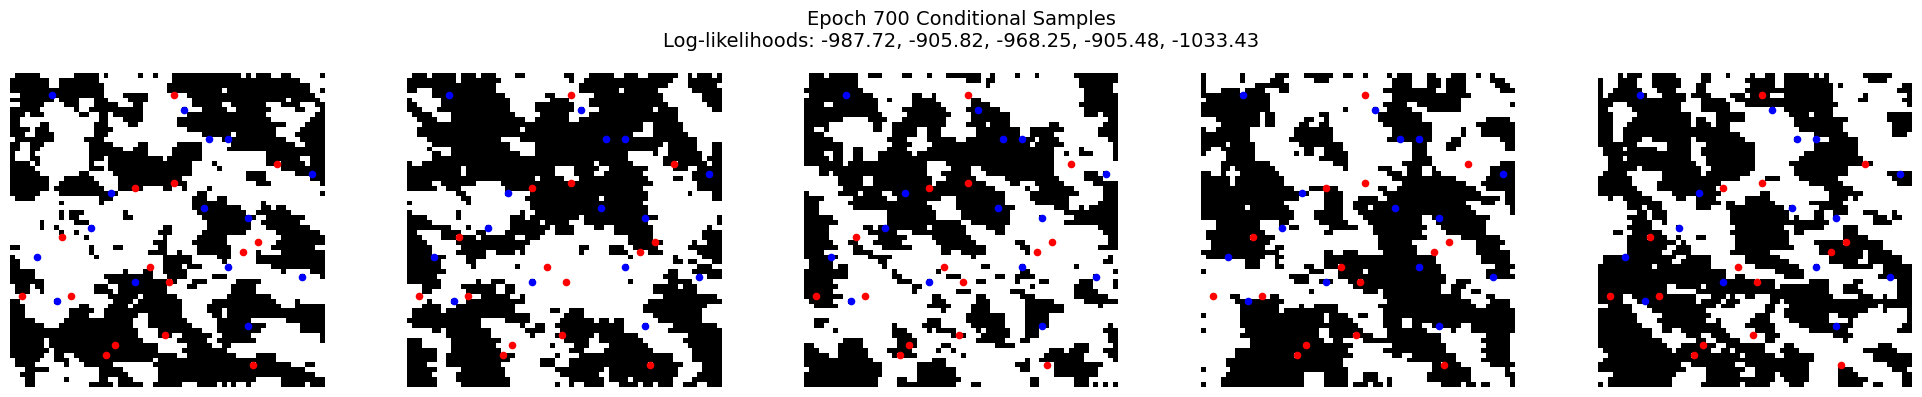

Loading checkpoint: vision_transformer_patch4x4_epoch800 (1).pth
Saved 1000 samples for epoch 800.


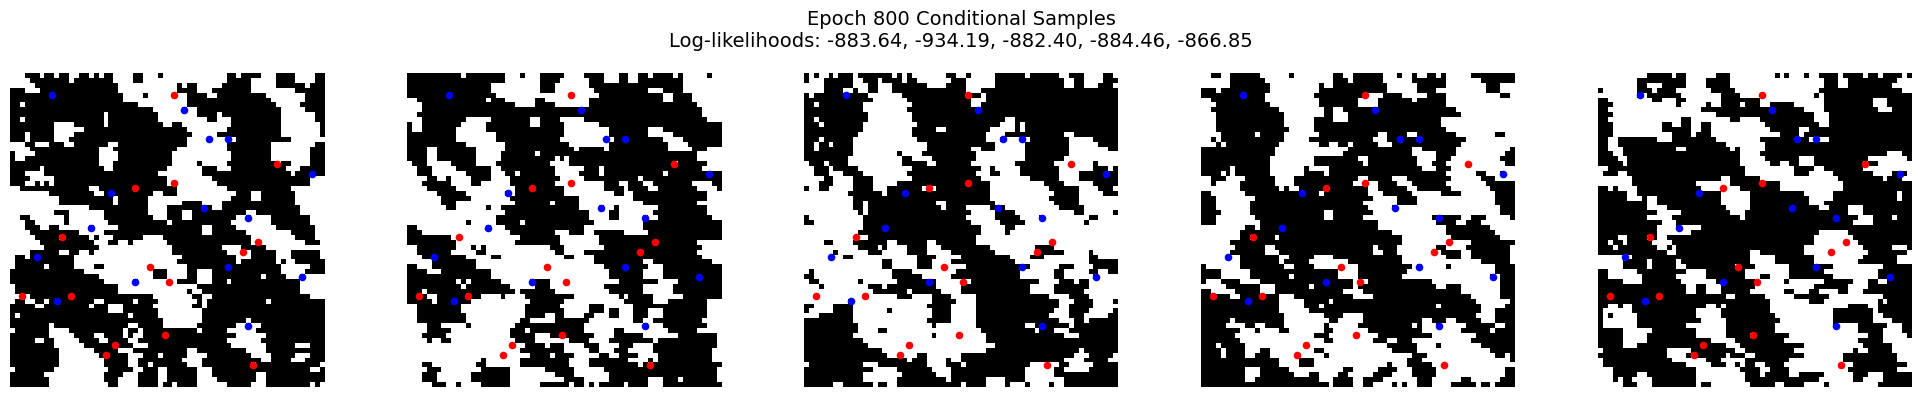

In [9]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import os

# =============================================================================
# Assumptions:
# - VisionTransformer, TransformerEncoderLayer, patch_to_int,
#   sample_image_conditional, and BinaryImageDataset with patches_to_image()
#   are defined exactly as in your training code.
# - The vocabulary (vocab) was saved during training to "vocab.pt"
# =============================================================================

# Parameters.
patch_size = 4
image_size = 64  # note: training images are 64x64 now (adjust if needed)

# Provided condition indices and values (global pixel indices over a flattened 64x64 image)
condition_indices = np.array([876,3825,2122,2892,1556,2683,3667,1767,483,2351,
                                2000,3312,2953,289,2373,2720,872,2713,1206,1341,
                                3541,2226,3423,1904,2882,2540,1497,2524,264,1441])
condition_values = np.array([0,1,1,1,0,0,1,0,0,1,0,0,0,1,0,1,0,0,1,0,
                               1,1,1,0,1,0,1,1,0,1])

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Build the model architecture with the same hyperparameters as training.
num_heads = 8
num_layers = 8
ffn_dim = 1024
hidden_dim = 256
dropout = 0.1

model = VisionTransformer(num_heads, num_layers, ffn_dim, hidden_dim, dropout)

arr = np.load("GeoDecepticon/Data/Markov_field/training_data.npz")["arr_0"]
training_data = arr[:9000]
training_data = training_data.reshape(-1, 64, 64)  # 60x60 images; adjust if needed.
print("Training data shape:", training_data.shape)
training_data = torch.tensor(training_data, dtype=torch.float32)
# Load the saved vocabulary so that the output projection has the correct dimensions.
vocab = model.build_vocabulary(training_data,patch_size)
model.vocab = vocab.to(device)
model.vocab_int = patch_to_int(model.vocab).to(device)
# Rebuild the output projection to match the vocab size.
model.output_projection = nn.Linear(model.hidden_dim, model.vocab.size(0)).to(device)
model = model.to(device)

# List of checkpoint epochs from which to generate samples.
checkpoint_epochs = list(range(300, 801, 100))
checkpoint_dir = ""  # Adjust if needed

# Create directory to save sample files.
save_dir = "./conditional_samples/"
os.makedirs(save_dir, exist_ok=True)

for epoch in checkpoint_epochs:
    ckpt_path = os.path.join(checkpoint_dir, f"vision_transformer_patch{patch_size}x{patch_size}_epoch{epoch} (1).pth")
    print(f"Loading checkpoint: {ckpt_path}")
    state_dict = torch.load(ckpt_path, map_location=device)
    model.load_state_dict(state_dict)
    model.eval()

    sample_imgs = []  # to store generated images (as tensors of shape (image_size, image_size))
    ll_values = []    # to store log likelihood values for each sample

    # Generate 1000 conditional samples.
    for i in range(1000):
        # sample_image_conditional is assumed to generate one image (in patch form)
        generated, ll = sample_image_conditional(model, patch_size, image_size,
                                                   temperature=1.0,
                                                   condition_indices=condition_indices,
                                                   condition_values=condition_values)
        # Convert patches (generated[0]) back to an image.
        gen_img = BinaryImageDataset.patches_to_image(generated[0], patch_size, image_size)
        sample_imgs.append(gen_img.cpu())  # store on CPU
        ll_values.append(ll)

    # Save the 1000 samples and their log-likelihoods in a compressed npz file.
    np.savez(os.path.join(save_dir, f"samples_epoch{epoch}.npz"),
             images=torch.stack(sample_imgs).numpy(),
             log_likelihoods=np.array(ll_values))
    print(f"Saved 1000 samples for epoch {epoch}.")

    # Plot the first 5 samples.
    fig, axes = plt.subplots(1, 5, figsize=(20, 4))
    fig.suptitle(f"Epoch {epoch} Conditional Samples\nLog-likelihoods: " +
                 ", ".join(f"{ll_values[i]:.2f}" for i in range(5)), fontsize=14)
    # For each plotted sample, overlay scatter points showing the generated value at condition indices.
    # Convert condition indices to (x, y) coordinates.
    x_coords = condition_indices % image_size
    y_coords = condition_indices // image_size
    for ax, img in zip(axes.flat, sample_imgs[:5]):
        img_np = img.numpy()
        ax.imshow(img_np, cmap='gray', vmin=0, vmax=1)
        # Extract generated pixel values at condition locations.
        gen_cond_vals = img_np[y_coords, x_coords]
        # Red dot for pixel value 1, blue for 0.
        red_mask = gen_cond_vals == 1
        blue_mask = gen_cond_vals == 0
        ax.scatter(x_coords[red_mask], y_coords[red_mask], color='red', s=20, marker='o')
        ax.scatter(x_coords[blue_mask], y_coords[blue_mask], color='blue', s=20, marker='o')
        ax.axis('off')
    plt.tight_layout()
    plt.show()

# Claude 3.7 Sonnet Thinking approach

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.cuda.amp import autocast, GradScaler
import wandb
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import time
import math

########################################
# Helper: Convert Patches to Integer Code
########################################

def patch_to_int(patches):
    """
    Converts a tensor of patches (shape: [N, patch_dim]) containing binary values
    to an integer code. Assumes values are near 0 or 1.
    """
    patches_bin = patches.round().long()  # ensure binary
    patch_dim = patches_bin.shape[1]
    powers = (2 ** torch.arange(patch_dim - 1, -1, -1, device=patches.device)).unsqueeze(0)
    codes = (patches_bin * powers).sum(dim=1)
    return codes

########################################
# Helper: Image sampling with improvements
########################################

def sample_image_conditional(model, patch_size, image_size, temperature=1.0,
                            condition_indices=None, condition_values=None,
                            top_k=40, adaptive_temp=True):
    """
    Generate one image using the autoregressive model while enforcing conditions.

    Args:
        model: The trained VisionTransformer model
        patch_size: Size of each patch (e.g., 3 for 3x3 patches)
        image_size: Size of the image (e.g., 60 for 60x60 images)
        temperature: Base temperature for sampling (higher = more diverse)
        condition_indices: numpy array of global pixel indices (from a flattened image)
        condition_values: numpy array of binary values corresponding to these indices
        top_k: If > 0, use top-k filtering to prevent low-probability tokens
        adaptive_temp: If True, decrease temperature as generation progresses

    Returns: (generated, log_likelihood)
      - generated: a tensor of shape (1, num_patches, patch_dim)
      - log_likelihood: the sum of log-probabilities for each patch token
    """
    num_patches = (image_size // patch_size) ** 2
    patch_dim = patch_size * patch_size

    # Initialize generated patches with the model's mask token
    generated = model.mask_token.detach().clone().unsqueeze(0).repeat(num_patches, 1)  # (num_patches, patch_dim)
    log_likelihood = 0.0

    # Pre-compute patch-level conditions
    patch_conditions = {}
    if condition_indices is not None and condition_values is not None:
        for cond_idx, cond_val in zip(condition_indices, condition_values):
            # Convert global pixel index to (row, col)
            global_row = int(cond_idx) // image_size
            global_col = int(cond_idx) % image_size
            # Determine which patch this falls into
            patch_row = global_row // patch_size
            patch_col = global_col // patch_size
            num_patches_per_row = image_size // patch_size
            patch_index = patch_row * num_patches_per_row + patch_col
            # Determine local index within the patch
            local_row = global_row % patch_size
            local_col = global_col % patch_size
            local_index = local_row * patch_size + local_col
            if patch_index not in patch_conditions:
                patch_conditions[patch_index] = {}
            patch_conditions[patch_index][local_index] = float(cond_val)

    generated = generated.unsqueeze(0)  # shape: (1, num_patches, patch_dim)

    # Track generation time
    start_time = time.time()

    # Sequentially generate patch tokens in raster-scan order
    for i in range(num_patches):
        # If conditions exist for this patch, get them
        cond = patch_conditions.get(i, None)

        # Forward pass: compute logits for the entire sequence
        with torch.no_grad(), autocast():
            logits = model(generated)  # shape: (1, num_patches, vocab_size)
            logits_i = logits[0, i]  # (vocab_size,)

            # Apply adaptive temperature scaling if enabled
            if adaptive_temp:
                # Start high, gradually reduce (diversity → quality)
                current_temp = temperature * (1.0 - 0.3 * (i / num_patches))
            else:
                current_temp = temperature

            logits_i = logits_i / current_temp

            # Apply top-k filtering
            if top_k > 0 and top_k < model.vocab_size:
                values, _ = torch.topk(logits_i, top_k)
                min_value = values[-1]
                logits_i = torch.where(logits_i < min_value,
                                      torch.full_like(logits_i, -float('inf')),
                                      logits_i)

        if cond is not None:
            # For each conditioned local pixel, restrict the distribution
            candidate_mask = torch.ones(model.vocab_size, dtype=torch.bool, device=logits_i.device)
            for local_idx, cond_val in cond.items():
                # For each token, check if its value at local_idx matches the condition
                candidate_mask = candidate_mask & (model.vocab[:, local_idx] == cond_val)
            logits_i = logits_i.masked_fill(~candidate_mask, -1e9)

        probs = torch.softmax(logits_i, dim=-1)
        token = torch.multinomial(probs, num_samples=1)

        # Accumulate log probability
        log_prob = torch.log(probs[token] + 1e-10)  # add epsilon for stability
        log_likelihood += log_prob.item()

        # Lookup the corresponding patch token from the vocabulary
        patch = model.vocab[token]
        generated[0, i] = patch

    generation_time = time.time() - start_time
    print(f"Generation completed in {generation_time:.2f}s for {num_patches} patches")

    return generated, log_likelihood

def generate_diverse_samples(model, patch_size, image_size, condition_indices=None,
                            condition_values=None, num_samples=3, base_temp=1.0):
    """
    Generate multiple diverse samples with the same conditions but different temperatures
    """
    samples = []
    log_probs = []

    # Generate with increasing temperatures for more diversity
    temps = [base_temp * (0.8 + 0.2 * i) for i in range(num_samples)]

    for i, temp in enumerate(temps):
        print(f"Generating sample {i+1}/{num_samples} with temperature {temp:.2f}")
        gen, ll = sample_image_conditional(
            model, patch_size, image_size,
            temperature=temp,
            condition_indices=condition_indices,
            condition_values=condition_values,
            top_k=40,  # Use top-k filtering
            adaptive_temp=True  # Use adaptive temperature
        )
        samples.append(gen)
        log_probs.append(ll)

    return samples, log_probs

########################################
# Improved Vision Transformer Components
########################################

class StochasticDepth(nn.Module):
    """
    Implements Stochastic Depth: randomly drops entire layers during training
    for regularization, similar to dropout but on a layer level.
    """
    def __init__(self, drop_prob=0.0):
        super().__init__()
        self.drop_prob = drop_prob

    def forward(self, x):
        if not self.training or self.drop_prob == 0:
            return x

        keep_prob = 1 - self.drop_prob
        shape = (x.shape[0],) + (1,) * (x.ndim - 1)
        random_tensor = keep_prob + torch.rand(shape, device=x.device)
        random_tensor = random_tensor.floor() / keep_prob
        return x * random_tensor

class ImprovedTransformerEncoderLayer(nn.Module):
    def __init__(self, hidden_dim, num_heads, ffn_dim, dropout=0.1, drop_path=0.0):
        super().__init__()
        # Pre-norm architecture
        self.norm1 = nn.LayerNorm(hidden_dim)
        self.norm2 = nn.LayerNorm(hidden_dim)

        # Multi-head attention
        self.self_attn = nn.MultiheadAttention(hidden_dim, num_heads, dropout=dropout, batch_first=True)

        # Expanded feed-forward network (wider for better capacity)
        expansion_factor = 4  # Standard is 4x in modern transformers
        self.linear1 = nn.Linear(hidden_dim, ffn_dim * expansion_factor)
        self.linear2 = nn.Linear(ffn_dim * expansion_factor, hidden_dim)

        self.dropout1 = nn.Dropout(dropout)
        self.dropout2 = nn.Dropout(dropout)
        self.activation = nn.GELU()

        # Stochastic depth for regularization
        self.drop_path = StochasticDepth(drop_path)

    def forward(self, z, attn_mask=None):
        # Pre-norm architecture (more stable training)
        z_norm = self.norm1(z)

        # Self-attention with proper masking handling
        if attn_mask is not None:
            # Convert boolean mask to float attention mask
            if attn_mask.dtype == torch.bool:
                attn_mask = attn_mask.float().masked_fill(
                    ~attn_mask, float("-inf")).masked_fill(attn_mask, float(0.0))

            attn_output, _ = self.self_attn(z_norm, z_norm, z_norm, attn_mask=attn_mask)
        else:
            attn_output, _ = self.self_attn(z_norm, z_norm, z_norm)

        # Apply residual connection with potential stochastic depth
        z = z + self.drop_path(self.dropout1(attn_output))

        # Feed-forward block also with pre-norm
        z_norm = self.norm2(z)
        ff_output = self.linear2(self.dropout2(self.activation(self.linear1(z_norm))))

        # Second residual connection
        z = z + self.drop_path(self.dropout2(ff_output))
        return z

class ImprovedVisionTransformer(nn.Module):
    """Enhanced Vision Transformer with improved architecture and training stability"""
    def __init__(self, num_heads, num_layers, ffn_dim, hidden_dim, dropout=0.1):
        super().__init__()
        self.hidden_dim = hidden_dim

        # Stochastic depth with increasing probability by depth
        dpr = [x.item() for x in torch.linspace(0, 0.2, num_layers)]

        # Improved transformer layers
        self.transformer_layers = nn.ModuleList([
            ImprovedTransformerEncoderLayer(
                hidden_dim, num_heads, ffn_dim, dropout, drop_path=dpr[i]
            ) for i in range(num_layers)
        ])

        self.dropout_layer = nn.Dropout(dropout)

        # Final layer norm (following modern architectures)
        self.norm = nn.LayerNorm(hidden_dim)

    def build_vocabulary(self, training_data, patch_size, full_mask=True, one_mask=True):
        self.patch_size = patch_size
        patch_dim = patch_size * patch_size

        # Assuming training_data shape is (N, H, W)
        H, W = training_data.shape[1], training_data.shape[2]
        num_patches = (H // patch_size) * (W // patch_size)

        # Extract non-overlapping patches using unfold (vectorized)
        patches_tensor = training_data.unfold(1, patch_size, patch_size)\
                                      .unfold(2, patch_size, patch_size)
        patches_tensor = patches_tensor.contiguous().view(-1, patch_dim)

        # Build vocabulary with a progress bar
        unique_set = set()
        unique_list = []

        for patch in tqdm(patches_tensor, desc=f"Building Vocabulary for {patch_size}x{patch_size}",
                      total=patches_tensor.shape[0]):
            patch_cpu = patch.cpu()  # force on CPU for uniqueness checking
            patch_tuple = tuple(patch_cpu.tolist())
            if patch_tuple not in unique_set:
                unique_set.add(patch_tuple)
                unique_list.append(patch_cpu)

        print(f"Found {len(unique_list)} unique patch patterns")

        # Add full mask token (a patch filled with 0.5)
        if full_mask:
            unique_list.append(torch.full((patch_dim,), 0.5, dtype=torch.float, device='cpu'))

        # Add one-mask tokens for each patch dimension
        if one_mask:
            for i in range(patch_dim):
                mask_patch = torch.full((patch_dim,), 0.5, dtype=torch.float, device='cpu')
                mask_patch[i] = 0.0
                unique_list.append(mask_patch)

                mask_patch = torch.full((patch_dim,), 0.5, dtype=torch.float, device='cpu')
                mask_patch[i] = 1.0
                unique_list.append(mask_patch)

        self.vocab = torch.stack(unique_list)  # shape: (vocab_size, patch_dim)
        self.vocab_size = self.vocab.size(0)

        # Precompute integer encoding for vocabulary tokens (for faster matching)
        self.vocab_int = patch_to_int(self.vocab)

        # Embedding projection: from patch_dim to hidden_dim
        self.embedding_projection = nn.Linear(patch_dim, self.hidden_dim)

        # Output projection: from hidden_dim to vocab size (to yield logits)
        self.output_projection = nn.Linear(self.hidden_dim, self.vocab_size)

        # Learned positional encoding for the number of patches (with proper initialization)
        self.pos_embedding = nn.Parameter(torch.zeros(1, num_patches, self.hidden_dim))

        # Learnable mask token
        self.mask_token = nn.Parameter(torch.full((patch_dim,), 0.5, dtype=torch.float))

        # Initialize weights
        self._init_weights()

        return self.vocab

    def _init_weights(self):
        """
        Initialize weights properly for transformer with improved stability
        """
        # Initialize embeddings
        nn.init.trunc_normal_(self.pos_embedding, std=0.02)

        # Initialize projection layers
        if hasattr(self, 'embedding_projection'):
            nn.init.trunc_normal_(self.embedding_projection.weight, std=0.02)
            if self.embedding_projection.bias is not None:
                nn.init.zeros_(self.embedding_projection.bias)

        if hasattr(self, 'output_projection'):
            nn.init.trunc_normal_(self.output_projection.weight, std=0.02)
            if self.output_projection.bias is not None:
                nn.init.zeros_(self.output_projection.bias)

        # Initialize mask token
        if hasattr(self, 'mask_token'):
            nn.init.normal_(self.mask_token, mean=0.5, std=0.01)

    def forward(self, patches, attn_mask=None):
        # patches shape: (batch_size, num_patches, patch_dim)
        batch_size, num_patches, _ = patches.shape

        # Convert patches to vector embeddings
        embeddings = self.embedding_projection(patches)

        # Add positional encoding
        embeddings = embeddings + self.pos_embedding[:, :num_patches, :]

        # Apply dropout
        z = self.dropout_layer(embeddings)

        # Pass through transformer encoder layers
        for layer in self.transformer_layers:
            z = layer(z, attn_mask=attn_mask)

        # Apply final layer norm
        z = self.norm(z)

        # Project to vocabulary space
        logits = self.output_projection(z)  # shape: (batch_size, num_patches, vocab_size)

        return logits

########################################
# Dataset and Patch Extraction
########################################

class BinaryImageDataset(Dataset):
    def __init__(self, images):
        self.images = images  # shape: (N, H, W)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        return self.images[idx]

    @staticmethod
    def batch_to_patches(images, patch_size):
        """Vectorized patch extraction for a batch"""
        B, H, W = images.shape
        patches = images.unfold(1, patch_size, patch_size).unfold(2, patch_size, patch_size)
        patches = patches.contiguous().view(B, -1, patch_size * patch_size)
        return patches

    @staticmethod
    def patches_to_image(patches, patch_size, image_size):
        """Convert patches to image (assumes patch order is in raster scan)"""
        image = torch.zeros(image_size, image_size, device=patches.device)
        idx = 0
        for i in range(0, image_size, patch_size):
            for j in range(0, image_size, patch_size):
                image[i:i+patch_size, j:j+patch_size] = patches[idx].view(patch_size, patch_size)
                idx += 1
        return image

########################################
# Vectorized Target Computation
########################################

def compute_targets_vectorized(patches, vocab, vocab_int=None):
    """
    Efficiently compute closest vocabulary token targets for all patches

    Args:
        patches: Tensor of shape [batch, num_patches, patch_dim] or [num_patches, patch_dim]
        vocab: Vocabulary tensor of shape [vocab_size, patch_dim]
        vocab_int: Optional precomputed integer codes for vocab (for binary data)

    Returns:
        targets: Long tensor of target indices with shape matching patches batch dims + []
    """
    # Handle both single image and batch cases
    orig_shape = patches.shape[:-1]  # Original batch dimensions

    # Reshape to 2D: [num_total_patches, patch_dim]
    if patches.dim() > 2:
        patches_flat = patches.reshape(-1, patches.shape[-1])
    else:
        patches_flat = patches

    # For binary data, use integer encoding for exact matching (much faster)
    if vocab_int is not None:
        # Convert patches to integer codes
        patch_codes = patch_to_int(patches_flat)

        # Initialize targets tensor
        targets_flat = torch.zeros(patches_flat.shape[0], dtype=torch.long, device=patches.device)

        # Match each patch to closest vocab token by matching integer codes
        # This is faster than computing distances for binary data
        for i, code in enumerate(patch_codes):
            # Find matching vocab entry
            matches = (vocab_int == code)
            if matches.any():
                # If exact match found, use it
                targets_flat[i] = matches.nonzero(as_tuple=True)[0][0]
            else:
                # If no exact match (shouldn't happen with binary data), fall back to L2
                distances = torch.sum((vocab - patches_flat[i:i+1]) ** 2, dim=1)
                targets_flat[i] = torch.argmin(distances)
    else:
        # For non-binary data or if vocab_int not provided, use L2 distance
        # Compute all pairwise distances using efficient cdist
        distances = torch.cdist(patches_flat, vocab)
        targets_flat = torch.argmin(distances, dim=1)

    # Reshape back to original batch dimensions
    targets = targets_flat.reshape(orig_shape)

    return targets

########################################
# Training Pipeline with All Improvements
########################################

def train_improved_model(patch_size, training_data, num_epochs=1000, batch_size=64,
                         eval_every=20, save_every=100):
    """
    Training pipeline with all the suggested improvements
    """
    # Enhanced hyperparameters
    num_heads = 8
    num_layers = 6
    ffn_dim = 512
    hidden_dim = 192  # Increased from 128

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    # Keep training data on CPU until needed
    image_size = training_data.shape[1]  # assume square images

    # Initialize wandb run with detailed config
    wandb.init(
        project="improved-vision-transformer",
        config={
            "architecture": "ImprovedVisionTransformer",
            "num_heads": num_heads,
            "num_layers": num_layers,
            "ffn_dim": ffn_dim,
            "hidden_dim": hidden_dim,
            "patch_size": patch_size,
            "num_epochs": num_epochs,
            "batch_size": batch_size,
            "optimizer": "AdamW",
            "weight_decay": 0.01,
            "learning_rate": 0.001,
            "scheduler": "CosineAnnealing",
            "mixed_precision": True,
            "stochastic_depth": True,
        },
        name=f"improved_patch_{patch_size}x{patch_size}"
    )

    # Build improved model
    model = ImprovedVisionTransformer(num_heads, num_layers, ffn_dim, hidden_dim, dropout=0.1)

    # Build vocabulary (using CPU data)
    print("Building vocabulary...")
    model.build_vocabulary(training_data, patch_size)

    # Move model to device after building vocabulary
    model = model.to(device)
    model.vocab = model.vocab.to(device)
    model.vocab_int = model.vocab_int.to(device)

    # Improved optimizer: AdamW with weight decay
    optimizer = torch.optim.AdamW(model.parameters(), lr=0.001, weight_decay=0.01, betas=(0.9, 0.999))

    # Learning rate scheduler
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs, eta_min=1e-5)

    # Loss function
    criterion = nn.CrossEntropyLoss()

    # Dataset and optimized DataLoader
    dataset = BinaryImageDataset(training_data)
    dataloader = DataLoader(
        dataset,
        batch_size=batch_size,
        shuffle=True,
        pin_memory=True,
        num_workers=4,
        persistent_workers=True
    )

    # Setup mixed precision training
    scaler = GradScaler()

    # Training metrics tracking
    best_loss = float('inf')

    # Global step for wandb logging
    global_step = 0

    # Track training time
    total_training_time = 0

    # Training loop
    for epoch in range(num_epochs):
        epoch_start = time.time()
        model.train()
        total_loss = 0.0

        # Progressive masking curriculum instead of random
        # Start with low masking rate, gradually increase
        mask_rate = min(0.85, 0.15 + (0.7 * epoch / (num_epochs * 0.8)))
        partial_mask_rate = 0.3  # 30% of masked patches will be partial

        # Create progress bar
        epoch_bar = tqdm(dataloader, desc=f"Epoch {epoch+1}/{num_epochs} (patch {patch_size}x{patch_size})")

        # Pre-compute mask tokens for efficiency
        full_mask_token = model.mask_token.clone().detach()

        batch_times = []

        for batch_idx, batch in enumerate(epoch_bar):
            batch_start = time.time()

            # Move batch to GPU
            batch = batch.to(device, non_blocking=True)
            B = batch.shape[0]

            # Convert to patches (single operation)
            patches = BinaryImageDataset.batch_to_patches(batch, patch_size)
            num_patches = patches.shape[1]
            patch_dim = patches.shape[2]

            # Create mask: for each patch in each image, mask with probability = mask_rate
            mask = torch.rand(B, num_patches, device=device) < mask_rate

            # Ensure at least one masked patch per sample
            for i in range(B):
                if not torch.any(mask[i]):
                    random_idx = torch.randint(0, num_patches, (1,), device=device)
                    mask[i, random_idx] = True

            # Decide which masked patches are partial vs. full (vectorized)
            partial = (torch.rand(B, num_patches, device=device) < partial_mask_rate) & mask
            full = mask & (~partial)

            # Create masked patches efficiently
            masked_patches = patches.clone()

            # Apply full masks (vectorized)
            if full.any():
                # Extract indices where full masking applies
                full_indices = torch.nonzero(full, as_tuple=True)
                masked_patches[full_indices] = full_mask_token

            # Apply partial masks
            if partial.any():
                # Get indices where partial masking applies
                partial_idx = torch.nonzero(partial, as_tuple=True)
                num_partial = len(partial_idx[0])

                # Create new patches with a single observed value
                new_patches = torch.full((num_partial, patch_dim), 0.5, device=device)
                rand_positions = torch.randint(0, patch_dim, (num_partial,), device=device)

                # Extract original values at random positions
                orig_vals = patches[partial_idx[0], partial_idx[1], :].gather(
                    1, rand_positions.unsqueeze(1)).squeeze(1)

                # Update new patches with observed values
                new_patches[torch.arange(num_partial, device=device), rand_positions] = orig_vals

                # Update masked patches
                masked_patches[partial_idx] = new_patches

            # Mixed precision forward pass
            with autocast():
                # Get model predictions
                logits = model(masked_patches)  # shape: (B, num_patches, vocab_size)

                # Compute targets efficiently
                targets = compute_targets_vectorized(patches, model.vocab, model.vocab_int)

                # Compute loss over all patches (or only masked ones)
                # Option 1: Loss only on masked patches
                masked_logits = logits.reshape(-1, model.vocab_size)[mask.reshape(-1)]
                masked_targets = targets.reshape(-1)[mask.reshape(-1)]
                loss = criterion(masked_logits, masked_targets)

                # Option 2: Full loss with masked patches weighted more
                # full_loss = criterion(logits.reshape(-1, model.vocab_size), targets.reshape(-1))
                # masked_loss = criterion(masked_logits, masked_targets)
                # loss = 0.3 * full_loss + 0.7 * masked_loss

            # Backward and optimize with mixed precision
            optimizer.zero_grad(set_to_none=True)  # More efficient than zero_grad()
            scaler.scale(loss).backward()

            # Optional: gradient clipping
            scaler.unscale_(optimizer)
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

            scaler.step(optimizer)
            scaler.update()

            # Track metrics
            total_loss += loss.item()
            batch_time = time.time() - batch_start
            batch_times.append(batch_time)

            # Update progress bar
            avg_batch_time = sum(batch_times[-10:]) / min(len(batch_times), 10)
            epoch_bar.set_postfix(
                loss=f"{loss.item():.4f}",
                mask_rate=f"{mask_rate:.2f}",
                batch_time=f"{avg_batch_time:.3f}s"
            )

            # Update global step
            global_step += 1

            # Visualize first batch of each epoch
            if batch_idx == 0:
                visualize_step = epoch * 10000  # Separate step space for visualization

                # Generate visualization
                with torch.no_grad(), autocast():
                    model.eval()

                    # Keep track of original, masked and reconstructed images
                    orig_img = batch[0].cpu()
                    masked_img = BinaryImageDataset.patches_to_image(
                        masked_patches[0], patch_size, image_size).cpu()

                    # Generate reconstructed image
                    recon_patches = masked_patches[0:1].clone()

                    # For masked patches, predict the most likely token
                    for p in range(num_patches):
                        if mask[0, p]:
                            # Forward pass for just this batch
                            patch_logits = model(recon_patches)
                            # Get the most likely token
                            patch_idx = torch.argmax(patch_logits[0, p])
                            # Replace with predicted token
                            recon_patches[0, p] = model.vocab[patch_idx]

                    # Convert to image
                    recon_img = BinaryImageDataset.patches_to_image(
                        recon_patches[0], patch_size, image_size).cpu()

                    # Log to wandb
                    wandb.log({
                        "visualization/original": wandb.Image(orig_img),
                        "visualization/masked": wandb.Image(masked_img),
                        "visualization/reconstructed": wandb.Image(recon_img)
                    }, step=visualize_step)

                    # Return to training mode
                    model.train()

        # End of epoch processing
        epoch_time = time.time() - epoch_start
        total_training_time += epoch_time
        avg_loss = total_loss / len(dataloader)

        # Step the learning rate scheduler
        scheduler.step()

        # Log metrics
        wandb.log({
            "training/epoch": epoch,
            "training/loss": avg_loss,
            "training/mask_rate": mask_rate,
            "training/learning_rate": scheduler.get_last_lr()[0],
            "training/epoch_time": epoch_time,
            "training/total_training_time": total_training_time
        }, step=global_step)

        # Print epoch summary
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {avg_loss:.4f}, "
              f"LR: {scheduler.get_last_lr()[0]:.6f}, Time: {epoch_time:.2f}s")

        # Save best model
        if avg_loss < best_loss:
            best_loss = avg_loss
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'scheduler_state_dict': scheduler.state_dict(),
                'loss': best_loss,
            }, f"improved_vit_patch{patch_size}x{patch_size}_best.pth")

            wandb.run.summary["best_loss"] = best_loss
            wandb.run.summary["best_epoch"] = epoch

        # Periodic evaluation
        if (epoch + 1) % eval_every == 0 or epoch == num_epochs - 1:
            model.eval()
            # Basic evaluation on a batch from the training set
            with torch.no_grad(), autocast():
                eval_batch = next(iter(dataloader)).to(device)
                eval_patches = BinaryImageDataset.batch_to_patches(eval_batch, patch_size)

                # Mask 50% of patches
                eval_mask = torch.rand(eval_batch.size(0), num_patches, device=device) < 0.5
                eval_masked = eval_patches.clone()
                eval_masked[eval_mask] = model.mask_token

                # Forward pass
                eval_logits = model(eval_masked)

                # Compute targets
                eval_targets = compute_targets_vectorized(eval_patches, model.vocab, model.vocab_int)

                # Compute accuracy (on masked patches only)
                masked_preds = torch.argmax(eval_logits[eval_mask], dim=1)
                masked_targets = eval_targets[eval_mask]
                accuracy = (masked_preds == masked_targets).float().mean().item()

                # Log eval metrics
                wandb.log({
                    "eval/accuracy": accuracy,
                }, step=global_step)

                print(f"Eval accuracy: {accuracy:.4f}")

        # Save checkpoint periodically
        if (epoch + 1) % save_every == 0 or epoch == num_epochs - 1:
            checkpoint_path = f"improved_vit_patch{patch_size}x{patch_size}_epoch{epoch+1}.pth"
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'scheduler_state_dict': scheduler.state_dict(),
                'loss': avg_loss,
                'best_loss': best_loss,
            }, checkpoint_path)

            # Generate conditional samples
            generate_conditional_samples(model, patch_size, image_size, device, global_step)

    # Final evaluation
    print("Training completed!")
    print(f"Best loss: {best_loss:.4f}")
    print(f"Total training time: {total_training_time:.2f}s")

    # Save final model
    torch.save(model.state_dict(), f"improved_vit_patch{patch_size}x{patch_size}_final.pth")

    # Finish wandb run
    wandb.finish()

    return model

def generate_conditional_samples(model, patch_size, image_size, device, step):
    """Generate and log conditional samples with the model"""
    model.eval()

    # Provided condition indices and values (global indices for a 60x60 image)
    condition_indices = np.array([876,2825,2122,2892,1556,2683,2667,1767,483,2351,2000,3312,2953,289,
                                  2373,2720,872,2713,1206,1341,3541,2226,3423,1904,2882,2540,1497,2524,264,1441])
    condition_values = np.array([0,1,1,1,0,0,1,0,0,1,0,0,0,1,0,1,0,0,1,0,1,1,1,0,1,0,1,1,0,1])

    # Create condition visualization
    cond_img = torch.zeros(image_size, image_size, device=device)
    for idx, val in zip(condition_indices, condition_values):
        row = idx // image_size
        col = idx % image_size
        cond_img[row, col] = val

    with torch.no_grad():
        # Generate diverse samples
        samples, log_likes = generate_diverse_samples(
            model, patch_size, image_size,
            condition_indices=condition_indices,
            condition_values=condition_values,
            num_samples=3
        )

        # Create figure with condition points and samples
        fig, axes = plt.subplots(1, 4, figsize=(20, 5))

        # Plot condition points
        axes[0].imshow(cond_img.cpu(), cmap='gray')
        axes[0].set_title("Condition Points")

        # Plot samples with different temperatures
        for i, (sample, ll) in enumerate(zip(samples, log_likes)):
            # Convert sample patches to image
            sample_img = BinaryImageDataset.patches_to_image(
                sample[0], patch_size, image_size)

            # Display
            axes[i+1].imshow(sample_img.cpu(), cmap='gray')
            axes[i+1].set_title(f"Sample {i+1}, LL: {ll:.2f}")

        # Save figure to wandb
        wandb.log({
            "conditional_generation/samples": wandb.Image(fig)
        }, step=step)
        plt.close(fig)

########################################
# Main Entry Point
########################################

def main():
    # Load and preprocess training data
    print("Loading training data...")
    arr = np.load("Data/Markov_field/training_data.npz")["arr_0"]
    training_data = arr[:9000]
    # Reshape to 60x60 images
    training_data = training_data.reshape(-1, 64, 64)[:, :60, :60]
    print(f"Training data shape: {training_data.shape}")

    # Convert to PyTorch tensor (keep on CPU initially)
    training_data = torch.tensor(training_data, dtype=torch.float32)

    # Train the model with optimized pipeline
    patch_size = 3  # 3x3 patches offer good balance for 60x60 binary images
    model = train_improved_model(
        patch_size=patch_size,
        training_data=training_data,
        num_epochs=1000,
        batch_size=64,
        eval_every=20,
        save_every=100
    )

    return model

if __name__ == "__main__":
    main()

Loading training data...
Training data shape: (9000, 60, 60)
Using device: cuda
Building vocabulary...


Building Vocabulary for 3x3: 100%|██████████| 3600000/3600000 [00:14<00:00, 253909.77it/s]
<ipython-input-14-44497637417b>:530: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Found 512 unique patch patterns


Epoch 1/1000 (patch 3x3):   0%|          | 0/141 [00:00<?, ?it/s]<ipython-input-14-44497637417b>:615: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 1/1000 (patch 3x3):   0%|          | 0/141 [00:03<?, ?it/s, batch_time=3.203s, loss=6.3101, mask_rate=0.15]<ipython-input-14-44497637417b>:665: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():
Epoch 1/1000 (patch 3x3):   6%|▋         | 9/141 [00:27<06:48,  3.10s/it, batch_time=2.851s, loss=4.1769, mask_rate=0.15]


KeyboardInterrupt: 

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import wandb
from tqdm import tqdm
import numpy as np
import multiprocessing

########################################
# Vision Transformer and Vocabulary
########################################

class VisionTransformer(nn.Module):
    def __init__(self, num_heads, num_layers, ffn_dim, hidden_dim, dropout=0.0):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.transformer_layers = nn.ModuleList([
            TransformerEncoderLayer(hidden_dim, num_heads, ffn_dim, dropout)
            for _ in range(num_layers)
        ])
        self.dropout_layer = nn.Dropout(dropout)

    def build_vocabulary(self, training_data, patch_size, full_mask=True, one_mask=True):
        self.patch_size = patch_size
        patch_dim = patch_size * patch_size
        # Assuming training_data shape is (N, H, W)
        H, W = training_data.shape[1], training_data.shape[2]
        num_patches = (H // patch_size) * (W // patch_size)

        # Extract non-overlapping patches using unfold.
        patches_tensor = training_data.unfold(1, patch_size, patch_size)\
                                        .unfold(2, patch_size, patch_size)
        patches_tensor = patches_tensor.contiguous().view(-1, patch_dim)

        # Build vocabulary with a progress bar.
        unique_set = set()
        unique_list = []
        for patch in tqdm(patches_tensor, desc=f"Building Vocabulary for {patch_size}x{patch_size}", total=patches_tensor.shape[0]):
            patch_cpu = patch.cpu()  # force on CPU for uniqueness checking
            patch_tuple = tuple(patch_cpu.tolist())
            if patch_tuple not in unique_set:
                unique_set.add(patch_tuple)
                unique_list.append(patch_cpu)
        # Add full mask token (a patch filled with 0.5)
        if full_mask:
            unique_list.append(torch.full((patch_dim,), 0.5, dtype=torch.float, device='cpu'))
        # Add one-mask tokens for each patch dimension.
        if one_mask:
            for i in range(patch_dim):
                mask_patch = torch.full((patch_dim,), 0.5, dtype=torch.float, device='cpu')
                mask_patch[i] = 0.0
                unique_list.append(mask_patch)
                mask_patch = torch.full((patch_dim,), 0.5, dtype=torch.float, device='cpu')
                mask_patch[i] = 1.0
                unique_list.append(mask_patch)

        self.vocab = torch.stack(unique_list)
        self.vocab_size = self.vocab.size(0)
        # Set up the embedding projection (from patch_dim to hidden_dim)
        self.embedding_projection = nn.Linear(patch_dim, self.hidden_dim)
        # Output projection: from hidden_dim to vocab size (to yield logits)
        self.output_projection = nn.Linear(self.hidden_dim, self.vocab_size)
        # Learned positional encoding for the number of patches.
        self.pos_embedding = nn.Parameter(torch.zeros(1, num_patches, self.hidden_dim))
        return self.vocab

    def forward(self, patches):
        # patches shape: (batch_size, num_patches, patch_dim)
        batch_size, num_patches, _ = patches.shape
        # Step 7: convert patches to vector embeddings
        embeddings = self.embedding_projection(patches)
        # Step 8: add positional encoding
        embeddings = embeddings + self.pos_embedding[:, :num_patches, :]
        z = self.dropout_layer(embeddings)
        # Step 9: pass through transformer encoder layers
        for layer in self.transformer_layers:
            z = layer(z)
        # Step 10: project context vectors to (batch, num_patches, vocab_size)
        logits = self.output_projection(z)
        return logits

class TransformerEncoderLayer(nn.Module):
    def __init__(self, hidden_dim, num_heads, ffn_dim, dropout=0.1):
        super().__init__()
        self.self_attn = nn.MultiheadAttention(hidden_dim, num_heads, dropout=dropout)
        self.linear1 = nn.Linear(hidden_dim, ffn_dim)
        self.linear2 = nn.Linear(ffn_dim, hidden_dim)
        self.norm1 = nn.LayerNorm(hidden_dim)
        self.norm2 = nn.LayerNorm(hidden_dim)
        self.dropout1 = nn.Dropout(dropout)
        self.dropout2 = nn.Dropout(dropout)
        self.activation = nn.GELU()

    def forward(self, z):
        # Self-attention block with residual connection.
        z_norm = self.norm1(z)
        z_t = z_norm.transpose(0, 1)
        attn_output, _ = self.self_attn(z_t, z_t, z_t)
        attn_output = attn_output.transpose(0, 1)
        z = z + self.dropout1(attn_output)
        # Feed-forward block with residual connection.
        z_norm = self.norm2(z)
        ff_output = self.linear2(self.dropout2(self.activation(self.linear1(z_norm))))
        z = z + self.dropout2(ff_output)
        return z

########################################
# Dataset and Patch Extraction
########################################

class BinaryImageDataset(Dataset):
    def __init__(self, images):
        self.images = images  # images shape: (N, H, W)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        return self.images[idx]

    @staticmethod
    def batch_to_patches(images, patch_size):
        # Vectorized patch extraction for a batch (images shape: (B, H, W))
        B, H, W = images.shape
        patches = images.unfold(1, patch_size, patch_size).unfold(2, patch_size, patch_size)
        patches = patches.contiguous().view(B, -1, patch_size * patch_size)
        return patches

    @staticmethod
    def patches_to_image(patches, patch_size, image_size):
        # Reconstruct an image from a list of patches.
        image = torch.zeros(image_size, image_size, device=patches.device)
        idx = 0
        for i in range(0, image_size, patch_size):
            for j in range(0, image_size, patch_size):
                image[i:i+patch_size, j:j+patch_size] = patches[idx].view(patch_size, patch_size)
                idx += 1
        return image

########################################
# Training Function for a Given Patch Size
########################################

def train_model_for_patch(patch_size, training_data, num_epochs=1000, batch_size=64):
    # Common hyperparameters.
    num_heads = 8
    num_layers = 6
    ffn_dim = 512
    hidden_dim = 128

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    training_data = training_data.to(device)
    image_size = training_data.shape[1]  # assume square images

    # Initialize a unique wandb run so that runs can be compared side by side.
    wandb.init(project="vision-transformer-comparison",
               config={
                   "num_heads": num_heads,
                   "num_layers": num_layers,
                   "ffn_dim": ffn_dim,
                   "hidden_dim": hidden_dim,
                   "patch_size": patch_size,
                   "num_epochs": num_epochs,
                   "batch_size": batch_size
               },
               name=f"patch_{patch_size}x{patch_size}",
               reinit=True)

    # Create the model and build its vocabulary.
    model = VisionTransformer(num_heads, num_layers, ffn_dim, hidden_dim, dropout=0.0)
    model.build_vocabulary(training_data, patch_size)
    model = model.to(device)
    model.vocab = model.vocab.to(device)

    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.CrossEntropyLoss()

    dataset = BinaryImageDataset(training_data)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    for epoch in range(num_epochs):
        model.train()
        total_loss = 0.0

        # Step 4: Increase mask rate linearly from a very small value (ensuring at least one mask) to 1.
        mask_rate = (epoch + 1) / num_epochs  # fraction of patches to mask
        partial_mask_rate = 0.3  # 30% of masked patches will be partial

        epoch_bar = tqdm(dataloader, desc=f"Epoch {epoch+1}/{num_epochs} (patch {patch_size}x{patch_size})", leave=False)
        for batch in epoch_bar:
            batch = batch.to(device)
            B = batch.shape[0]
            # Step 5: Convert the batch to patches.
            patches = BinaryImageDataset.batch_to_patches(batch, patch_size)
            num_patches = patches.shape[1]
            patch_dim = patches.shape[2]

            # Step 6: Determine which patches to mask.
            mask = torch.rand(B, num_patches, device=device) < mask_rate
            mask[:, 0] = True  # Ensure at least one masked patch per sample

            # Decide which masks are partial (30%) and which are full.
            partial = (torch.rand(B, num_patches, device=device) < partial_mask_rate) & mask
            full = mask & (~partial)

            masked_patches = patches.clone()
            # For full masks, use the full mask token (last token in vocab).
            if full.any():
                masked_patches[full] = model.vocab[-1]
            # For partial masks, fill with 0.5 and restore one randomly chosen element.
            if partial.any():
                partial_idx = torch.nonzero(partial)
                num_partial = partial_idx.shape[0]
                new_patches = torch.full((num_partial, patch_dim), 0.5, device=device)
                rand_positions = torch.randint(0, patch_dim, (num_partial,), device=device)
                orig_vals = patches[partial_idx[:, 0], partial_idx[:, 1], :].gather(1, rand_positions.unsqueeze(1)).squeeze(1)
                new_patches[torch.arange(num_partial), rand_positions] = orig_vals
                masked_patches[partial_idx[:, 0], partial_idx[:, 1]] = new_patches

            # Steps 7–10: Forward pass
            logits = model(masked_patches)  # logits shape: (B, num_patches, vocab_size)

            # Step 11–12: Compute the target token for each patch and select only masked patches.
            all_patches = patches.view(B * num_patches, patch_dim)
            vocab = model.vocab  # (vocab_size, patch_dim)
            dists = torch.cdist(all_patches, vocab, p=2) ** 2  # squared Euclidean distances
            targets_all = torch.argmin(dists, dim=1).view(B, num_patches)
            masked_targets = targets_all[mask]

            loss = criterion(logits[mask], masked_targets)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            epoch_bar.set_postfix(loss=loss.item(), mask_rate=mask_rate)

        avg_loss = total_loss / len(dataloader)
        wandb.log({"epoch": epoch, "loss": avg_loss, "mask_rate": mask_rate})
        print(f"[Patch {patch_size}x{patch_size}] Epoch {epoch+1}/{num_epochs}, Loss: {avg_loss:.4f}, Mask Rate: {mask_rate:.2f}")

        # Save a checkpoint every 100 epochs.
        if (epoch + 1) % 100 == 0:
            torch.save(model.state_dict(), f"vision_transformer_patch{patch_size}x{patch_size}_epoch{epoch+1}.pth")

    wandb.finish()
    return model

########################################
# Main: Train All Models
########################################

if __name__ == "__main__":
    # Load training data (assumed shape: (9000, 60, 60) after reshaping)
    arr = np.load("Data/Markov_field/training_data.npz")["arr_0"]
    training_data = arr[:9000]
    # Reshape to 60x60 images (adjust if needed)
    training_data = training_data.reshape(-1, 64, 64)[:, :60, :60]
    print("Training data shape:", training_data.shape)
    training_data = torch.tensor(training_data, dtype=torch.float32)

    # Train models for patch sizes 2x2, 3x3, and 4x4 using the same parameters.
    patch_sizes = [2, 3, 4]
    models = {}
    for ps in patch_sizes:
        print(f"\nTraining model for patch size {ps}x{ps}")
        models[ps] = train_model_for_patch(ps, training_data)

    # With wandb, the runs will appear side by side in your project dashboard.

Training data shape: (9000, 60, 60)

Training model for patch size 2x2


wandb: ERROR Control-C detected -- Run data was not synced


KeyboardInterrupt: 

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import wandb
from tqdm import tqdm
import numpy as np
import multiprocessing

########################################
# Helper: Convert Patches to Integer Code
########################################

def patch_to_int(patches):
    """
    Converts a tensor of patches (shape: [N, patch_dim]) containing binary values
    to an integer code. Assumes values are near 0 or 1.
    """
    patches_bin = patches.round().long()  # ensure binary
    patch_dim = patches_bin.shape[1]
    powers = (2 ** torch.arange(patch_dim - 1, -1, -1, device=patches.device)).unsqueeze(0)
    codes = (patches_bin * powers).sum(dim=1)
    return codes

########################################
# Vision Transformer and Vocabulary
########################################

class VisionTransformer(nn.Module):
    def __init__(self, num_heads, num_layers, ffn_dim, hidden_dim, dropout=0.0):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.transformer_layers = nn.ModuleList([
            TransformerEncoderLayer(hidden_dim, num_heads, ffn_dim, dropout)
            for _ in range(num_layers)
        ])
        self.dropout_layer = nn.Dropout(dropout)

    def build_vocabulary(self, training_data, patch_size, full_mask=True, one_mask=True):
        self.patch_size = patch_size
        patch_dim = patch_size * patch_size
        # Assuming training_data shape is (N, H, W)
        H, W = training_data.shape[1], training_data.shape[2]
        num_patches = (H // patch_size) * (W // patch_size)

        # Extract non-overlapping patches using unfold.
        patches_tensor = training_data.unfold(1, patch_size, patch_size)\
                                        .unfold(2, patch_size, patch_size)
        patches_tensor = patches_tensor.contiguous().view(-1, patch_dim)

        # Build vocabulary with a progress bar.
        unique_set = set()
        unique_list = []
        for patch in tqdm(patches_tensor, desc=f"Building Vocabulary for {patch_size}x{patch_size}", total=patches_tensor.shape[0]):
            patch_cpu = patch.cpu()  # force on CPU for uniqueness checking
            patch_tuple = tuple(patch_cpu.tolist())
            if patch_tuple not in unique_set:
                unique_set.add(patch_tuple)
                unique_list.append(patch_cpu)
        # Add full mask token (a patch filled with 0.5) to the vocabulary if desired.
        if full_mask:
            unique_list.append(torch.full((patch_dim,), 0.5, dtype=torch.float, device='cpu'))
        # Add one-mask tokens for each patch dimension.
        if one_mask:
            for i in range(patch_dim):
                mask_patch = torch.full((patch_dim,), 0.5, dtype=torch.float, device='cpu')
                mask_patch[i] = 0.0
                unique_list.append(mask_patch)
                mask_patch = torch.full((patch_dim,), 0.5, dtype=torch.float, device='cpu')
                mask_patch[i] = 1.0
                unique_list.append(mask_patch)

        self.vocab = torch.stack(unique_list)
        self.vocab_size = self.vocab.size(0)
        # Precompute integer encoding for vocabulary tokens.
        self.vocab_int = patch_to_int(self.vocab)
        # Set up the embedding projection (from patch_dim to hidden_dim)
        self.embedding_projection = nn.Linear(patch_dim, self.hidden_dim)
        # Output projection: from hidden_dim to vocab size (to yield logits)
        self.output_projection = nn.Linear(self.hidden_dim, self.vocab_size)
        # Learned positional encoding for the number of patches.
        self.pos_embedding = nn.Parameter(torch.zeros(1, num_patches, self.hidden_dim))
        # --- Learnable Mask Token ---
        self.mask_token = nn.Parameter(torch.full((patch_dim,), 0.5, dtype=torch.float))
        return self.vocab

    def forward(self, patches):
        # patches shape: (batch_size, num_patches, patch_dim)
        batch_size, num_patches, _ = patches.shape
        # Convert patches to vector embeddings.
        embeddings = self.embedding_projection(patches)
        # Add positional encoding.
        embeddings = embeddings + self.pos_embedding[:, :num_patches, :]
        z = self.dropout_layer(embeddings)
        # Pass through transformer encoder layers.
        for layer in self.transformer_layers:
            z = layer(z)
        # Project context vectors to (batch, num_patches, vocab_size)
        logits = self.output_projection(z)
        return logits

class TransformerEncoderLayer(nn.Module):
    def __init__(self, hidden_dim, num_heads, ffn_dim, dropout=0.1):
        super().__init__()
        self.self_attn = nn.MultiheadAttention(hidden_dim, num_heads, dropout=dropout)
        self.linear1 = nn.Linear(hidden_dim, ffn_dim)
        self.linear2 = nn.Linear(ffn_dim, hidden_dim)
        self.norm1 = nn.LayerNorm(hidden_dim)
        self.norm2 = nn.LayerNorm(hidden_dim)
        self.dropout1 = nn.Dropout(dropout)
        self.dropout2 = nn.Dropout(dropout)
        self.activation = nn.GELU()

    def forward(self, z):
        # Self-attention block with residual connection.
        z_norm = self.norm1(z)
        z_t = z_norm.transpose(0, 1)
        attn_output, _ = self.self_attn(z_t, z_t, z_t)
        attn_output = attn_output.transpose(0, 1)
        z = z + self.dropout1(attn_output)
        # Feed-forward block with residual connection.
        z_norm = self.norm2(z)
        ff_output = self.linear2(self.dropout2(self.activation(self.linear1(z_norm))))
        z = z + self.dropout2(ff_output)
        return z

########################################
# Dataset and Patch Extraction
########################################

class BinaryImageDataset(Dataset):
    def __init__(self, images):
        self.images = images  # images shape: (N, H, W)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        return self.images[idx]

    @staticmethod
    def batch_to_patches(images, patch_size):
        # Vectorized patch extraction for a batch (images shape: (B, H, W))
        B, H, W = images.shape
        patches = images.unfold(1, patch_size, patch_size).unfold(2, patch_size, patch_size)
        patches = patches.contiguous().view(B, -1, patch_size * patch_size)
        return patches

    @staticmethod
    def patches_to_image(patches, patch_size, image_size):
        # Reconstruct an image from a list of patches.
        image = torch.zeros(image_size, image_size, device=patches.device)
        idx = 0
        for i in range(0, image_size, patch_size):
            for j in range(0, image_size, patch_size):
                image[i:i+patch_size, j:j+patch_size] = patches[idx].view(patch_size, patch_size)
                idx += 1
        return image

########################################
# Training Function for a Given Patch Size
########################################

def train_model_for_patch(patch_size, training_data, num_epochs=1000, batch_size=64):
    # Common hyperparameters.
    num_heads = 8
    num_layers = 6
    ffn_dim = 512
    hidden_dim = 256

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    training_data = training_data.to(device)
    image_size = training_data.shape[1]  # assume square images

    # Initialize a unique wandb run for side-by-side comparison.
    wandb.init(project="vision-transformer-comparison",
               config={
                   "num_heads": num_heads,
                   "num_layers": num_layers,
                   "ffn_dim": ffn_dim,
                   "hidden_dim": hidden_dim,
                   "patch_size": patch_size,
                   "num_epochs": num_epochs,
                   "batch_size": batch_size
               },
               name=f"patch_{patch_size}x{patch_size}",
               reinit=True)

    # Create the model and build its vocabulary.
    model = VisionTransformer(num_heads, num_layers, ffn_dim, hidden_dim, dropout=0.0)
    model.build_vocabulary(training_data, patch_size)
    model = model.to(device)
    model.vocab = model.vocab.to(device)
    model.vocab_int = patch_to_int(model.vocab).to(device)  # Precompute vocab codes

    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.CrossEntropyLoss()

    dataset = BinaryImageDataset(training_data)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    for epoch in range(num_epochs):
        model.train()
        total_loss = 0.0

        # --- Random Mask Schedule ---
        # For each epoch, sample a random mask rate between 10% and 100%.
        mask_rate = np.random.uniform(0.1, 1.0)
        partial_mask_rate = 0.3  # 30% of masked patches will be partial

        epoch_bar = tqdm(dataloader, desc=f"Epoch {epoch+1}/{num_epochs} (patch {patch_size}x{patch_size})", leave=False)
        for batch in epoch_bar:
            batch = batch.to(device)
            B = batch.shape[0]
            # Convert the batch to patches.
            patches = BinaryImageDataset.batch_to_patches(batch, patch_size)
            num_patches = patches.shape[1]
            patch_dim = patches.shape[2]

            # Determine which patches to mask using the random mask rate.
            mask = torch.rand(B, num_patches, device=device) < mask_rate
            mask[:, 0] = True  # Ensure at least one masked patch per sample

            # Decide which masked patches are partial vs. full.
            partial = (torch.rand(B, num_patches, device=device) < partial_mask_rate) & mask
            full = mask & (~partial)

            masked_patches = patches.clone()
            # For full masks, use the learnable mask token.
            if full.any():
                masked_patches[full] = model.mask_token
            # For partial masks, fill with 0.5 and restore one randomly chosen element.
            if partial.any():
                partial_idx = torch.nonzero(partial)
                num_partial = partial_idx.shape[0]
                new_patches = torch.full((num_partial, patch_dim), 0.5, device=device)
                rand_positions = torch.randint(0, patch_dim, (num_partial,), device=device)
                orig_vals = patches[partial_idx[:, 0], partial_idx[:, 1], :].gather(1, rand_positions.unsqueeze(1)).squeeze(1)
                new_patches[torch.arange(num_partial), rand_positions] = orig_vals
                masked_patches[partial_idx[:, 0], partial_idx[:, 1]] = new_patches

            # Forward pass: get logits (shape: [B, num_patches, vocab_size]).
            logits = model(masked_patches)

            # --- Full Target Computation ---
            # Compute integer codes for every original patch.
            all_patches = patches.view(B * num_patches, patch_dim)
            codes = patch_to_int(all_patches)  # shape: (B*num_patches,)
            vocab_codes = model.vocab_int  # shape: (vocab_size,)
            mask_eq = codes.unsqueeze(1) == vocab_codes.unsqueeze(0)
            target_indices = mask_eq.float().argmax(dim=1)  # shape: (B*num_patches,)
            targets_all = target_indices.view(B, num_patches)
            # Compute loss over all patches.
            loss = criterion(logits.view(-1, model.vocab_size), targets_all.view(-1))
            # ---------------------------------

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            epoch_bar.set_postfix(loss=loss.item(), mask_rate=mask_rate)

        avg_loss = total_loss / len(dataloader)
        wandb.log({"epoch": epoch, "loss": avg_loss, "mask_rate": mask_rate})
        print(f"[Patch {patch_size}x{patch_size}] Epoch {epoch+1}/{num_epochs}, Loss: {avg_loss:.4f}, Mask Rate: {mask_rate:.2f}")

        # Save a checkpoint every 100 epochs.
        if (epoch + 1) % 100 == 0:
            torch.save(model.state_dict(), f"vision_transformer_patch{patch_size}x{patch_size}_epoch{epoch+1}.pth")

    wandb.finish()
    return model

########################################
# Main: Train All Models
########################################

if __name__ == "__main__":
    # Load training data (assumed shape: (9000, 60, 60) after reshaping)
    arr = np.load("Data/Markov_field/training_data.npz")["arr_0"]
    training_data = arr[:9000]
    # Reshape to 60x60 images (adjust if needed)
    training_data = training_data.reshape(-1, 64, 64)[:, :60, :60]
    print("Training data shape:", training_data.shape)
    training_data = torch.tensor(training_data, dtype=torch.float32)

    # Train models for patch sizes 2x2, 3x3, and 4x4 using the same parameters.
    patch_sizes = [3, 4]
    models = {}
    for ps in patch_sizes:
        print(f"\nTraining model for patch size {ps}x{ps}")
        models[ps] = train_model_for_patch(ps, training_data)

    # With wandb, the runs will appear side by side in your project dashboard.

Training data shape: (9000, 60, 60)

Training model for patch size 3x3


Building Vocabulary for 3x3: 100%|██████████| 3600000/3600000 [01:22<00:00, 43526.94it/s]


[Patch 3x3] Epoch 1/1000, Loss: 3.5374, Mask Rate: 0.79


[Patch 3x3] Epoch 2/1000, Loss: 2.7708, Mask Rate: 0.80


[Patch 3x3] Epoch 3/1000, Loss: 1.9159, Mask Rate: 0.57


[Patch 3x3] Epoch 4/1000, Loss: 1.6463, Mask Rate: 0.49


[Patch 3x3] Epoch 5/1000, Loss: 0.9271, Mask Rate: 0.28


[Patch 3x3] Epoch 6/1000, Loss: 2.7681, Mask Rate: 0.83


[Patch 3x3] Epoch 7/1000, Loss: 1.4006, Mask Rate: 0.42


[Patch 3x3] Epoch 8/1000, Loss: 3.0961, Mask Rate: 0.93


[Patch 3x3] Epoch 9/1000, Loss: 1.7360, Mask Rate: 0.52


[Patch 3x3] Epoch 10/1000, Loss: 2.1311, Mask Rate: 0.64


[Patch 3x3] Epoch 11/1000, Loss: 1.2334, Mask Rate: 0.37


[Patch 3x3] Epoch 12/1000, Loss: 2.3734, Mask Rate: 0.72


[Patch 3x3] Epoch 13/1000, Loss: 1.2521, Mask Rate: 0.38


[Patch 3x3] Epoch 14/1000, Loss: 2.1787, Mask Rate: 0.66


[Patch 3x3] Epoch 15/1000, Loss: 2.2240, Mask Rate: 0.67


[Patch 3x3] Epoch 16/1000, Loss: 1.4163, Mask Rate: 0.43


[Patch 3x3] Epoch 17/1000, Loss: 1.1280, Mask Rate: 0.35


[Patch 3x3] Epoch 18/1000, Loss: 0.7193, Mask Rate: 0.23


[Patch 3x3] Epoch 19/1000, Loss: 9.1959, Mask Rate: 0.65


[Patch 3x3] Epoch 20/1000, Loss: 3.4708, Mask Rate: 0.86


[Patch 3x3] Epoch 21/1000, Loss: 3.4526, Mask Rate: 0.93


[Patch 3x3] Epoch 22/1000, Loss: 3.1252, Mask Rate: 0.87


[Patch 3x3] Epoch 23/1000, Loss: 2.1927, Mask Rate: 0.62


[Patch 3x3] Epoch 24/1000, Loss: 2.4351, Mask Rate: 0.72


[Patch 3x3] Epoch 25/1000, Loss: 2.2617, Mask Rate: 0.67


[Patch 3x3] Epoch 26/1000, Loss: 3.4519, Mask Rate: 0.99


[Patch 3x3] Epoch 27/1000, Loss: 1.3564, Mask Rate: 0.39


[Patch 3x3] Epoch 28/1000, Loss: 3.2152, Mask Rate: 0.95


[Patch 3x3] Epoch 29/1000, Loss: 2.8952, Mask Rate: 0.88


[Patch 3x3] Epoch 30/1000, Loss: 2.4469, Mask Rate: 0.75


[Patch 3x3] Epoch 31/1000, Loss: 0.7765, Mask Rate: 0.24


[Patch 3x3] Epoch 32/1000, Loss: 0.4281, Mask Rate: 0.14


[Patch 3x3] Epoch 33/1000, Loss: 2.5819, Mask Rate: 0.81


[Patch 3x3] Epoch 34/1000, Loss: 2.9465, Mask Rate: 0.92


[Patch 3x3] Epoch 35/1000, Loss: 2.1543, Mask Rate: 0.69


[Patch 3x3] Epoch 36/1000, Loss: 2.5414, Mask Rate: 0.81


[Patch 3x3] Epoch 37/1000, Loss: 1.1537, Mask Rate: 0.38


[Patch 3x3] Epoch 38/1000, Loss: 2.0382, Mask Rate: 0.66


[Patch 3x3] Epoch 39/1000, Loss: 1.9347, Mask Rate: 0.63


[Patch 3x3] Epoch 40/1000, Loss: 2.2219, Mask Rate: 0.72


[Patch 3x3] Epoch 41/1000, Loss: 1.3868, Mask Rate: 0.46


[Patch 3x3] Epoch 42/1000, Loss: 3.0961, Mask Rate: 0.96


[Patch 3x3] Epoch 43/1000, Loss: 2.6292, Mask Rate: 0.84


[Patch 3x3] Epoch 44/1000, Loss: 0.7906, Mask Rate: 0.27


[Patch 3x3] Epoch 45/1000, Loss: 2.0880, Mask Rate: 0.68


[Patch 3x3] Epoch 46/1000, Loss: 1.8018, Mask Rate: 0.60


[Patch 3x3] Epoch 47/1000, Loss: 2.8726, Mask Rate: 0.91


[Patch 3x3] Epoch 48/1000, Loss: 1.6598, Mask Rate: 0.56


[Patch 3x3] Epoch 49/1000, Loss: 2.0836, Mask Rate: 0.69


[Patch 3x3] Epoch 50/1000, Loss: 1.4938, Mask Rate: 0.52


[Patch 3x3] Epoch 51/1000, Loss: 1.0191, Mask Rate: 0.39


[Patch 3x3] Epoch 52/1000, Loss: 1.9715, Mask Rate: 0.69


[Patch 3x3] Epoch 53/1000, Loss: 1.1141, Mask Rate: 0.43


[Patch 3x3] Epoch 54/1000, Loss: 1.4749, Mask Rate: 0.55


[Patch 3x3] Epoch 55/1000, Loss: 19.1214, Mask Rate: 0.98


[Patch 3x3] Epoch 56/1000, Loss: 2.7329, Mask Rate: 0.50


[Patch 3x3] Epoch 57/1000, Loss: 0.5388, Mask Rate: 0.13


[Patch 3x3] Epoch 58/1000, Loss: 0.3897, Mask Rate: 0.11


[Patch 3x3] Epoch 59/1000, Loss: 2.6179, Mask Rate: 0.66


[Patch 3x3] Epoch 60/1000, Loss: 3.1949, Mask Rate: 0.92


[Patch 3x3] Epoch 61/1000, Loss: 2.0741, Mask Rate: 0.64


[Patch 3x3] Epoch 62/1000, Loss: 0.5015, Mask Rate: 0.16


[Patch 3x3] Epoch 63/1000, Loss: 1.5623, Mask Rate: 0.50


[Patch 3x3] Epoch 64/1000, Loss: 1.3359, Mask Rate: 0.43


[Patch 3x3] Epoch 65/1000, Loss: 1.3598, Mask Rate: 0.45


[Patch 3x3] Epoch 66/1000, Loss: 2.9182, Mask Rate: 0.89


[Patch 3x3] Epoch 67/1000, Loss: 1.1799, Mask Rate: 0.41


[Patch 3x3] Epoch 68/1000, Loss: 3.0386, Mask Rate: 0.93


[Patch 3x3] Epoch 69/1000, Loss: 1.5361, Mask Rate: 0.53


[Patch 3x3] Epoch 70/1000, Loss: 2.3014, Mask Rate: 0.76


[Patch 3x3] Epoch 71/1000, Loss: 0.8552, Mask Rate: 0.32


[Patch 3x3] Epoch 72/1000, Loss: 1.0759, Mask Rate: 0.40


[Patch 3x3] Epoch 73/1000, Loss: 1.3598, Mask Rate: 0.49


[Patch 3x3] Epoch 74/1000, Loss: 1.0351, Mask Rate: 0.39


[Patch 3x3] Epoch 75/1000, Loss: 1.2643, Mask Rate: 0.46


[Patch 3x3] Epoch 76/1000, Loss: 5.3187, Mask Rate: 0.92


[Patch 3x3] Epoch 77/1000, Loss: 2.8289, Mask Rate: 0.88


[Patch 3x3] Epoch 78/1000, Loss: 1.7526, Mask Rate: 0.60


[Patch 3x3] Epoch 79/1000, Loss: 0.7599, Mask Rate: 0.29


[Patch 3x3] Epoch 80/1000, Loss: 0.8225, Mask Rate: 0.31


[Patch 3x3] Epoch 81/1000, Loss: 0.7773, Mask Rate: 0.30


[Patch 3x3] Epoch 82/1000, Loss: 1.2876, Mask Rate: 0.47


[Patch 3x3] Epoch 83/1000, Loss: 1.8811, Mask Rate: 0.66


[Patch 3x3] Epoch 84/1000, Loss: 1.8636, Mask Rate: 0.66


[Patch 3x3] Epoch 85/1000, Loss: 1.3846, Mask Rate: 0.51


[Patch 3x3] Epoch 86/1000, Loss: 0.5714, Mask Rate: 0.23


[Patch 3x3] Epoch 87/1000, Loss: 0.9096, Mask Rate: 0.35


[Patch 3x3] Epoch 88/1000, Loss: 2.4373, Mask Rate: 0.81


[Patch 3x3] Epoch 89/1000, Loss: 3.1512, Mask Rate: 0.98


[Patch 3x3] Epoch 90/1000, Loss: 1.0870, Mask Rate: 0.26


[Patch 3x3] Epoch 91/1000, Loss: 0.6837, Mask Rate: 0.26


[Patch 3x3] Epoch 92/1000, Loss: 0.3182, Mask Rate: 0.12


[Patch 3x3] Epoch 93/1000, Loss: 2.3078, Mask Rate: 0.70


[Patch 3x3] Epoch 94/1000, Loss: 0.6114, Mask Rate: 0.23


[Patch 3x3] Epoch 95/1000, Loss: 2.9187, Mask Rate: 0.91


[Patch 3x3] Epoch 96/1000, Loss: 0.5290, Mask Rate: 0.20


[Patch 3x3] Epoch 97/1000, Loss: 1.3419, Mask Rate: 0.49


[Patch 3x3] Epoch 98/1000, Loss: 1.9882, Mask Rate: 0.69


[Patch 3x3] Epoch 99/1000, Loss: 2.5867, Mask Rate: 0.85


[Patch 3x3] Epoch 100/1000, Loss: 1.5245, Mask Rate: 0.56


[Patch 3x3] Epoch 101/1000, Loss: 2.1008, Mask Rate: 0.73


[Patch 3x3] Epoch 102/1000, Loss: 2.1437, Mask Rate: 0.74


[Patch 3x3] Epoch 103/1000, Loss: 2.1077, Mask Rate: 0.73


[Patch 3x3] Epoch 104/1000, Loss: 3.1560, Mask Rate: 0.99


[Patch 3x3] Epoch 105/1000, Loss: 1.3789, Mask Rate: 0.51


[Patch 3x3] Epoch 106/1000, Loss: 1.5217, Mask Rate: 0.57


[Patch 3x3] Epoch 107/1000, Loss: 0.3249, Mask Rate: 0.14


[Patch 3x3] Epoch 108/1000, Loss: 2.7840, Mask Rate: 0.91


[Patch 3x3] Epoch 109/1000, Loss: 2.0678, Mask Rate: 0.73


[Patch 3x3] Epoch 110/1000, Loss: 0.7620, Mask Rate: 0.31


[Patch 3x3] Epoch 111/1000, Loss: 1.5455, Mask Rate: 0.58


[Patch 3x3] Epoch 112/1000, Loss: 2.5514, Mask Rate: 0.86


[Patch 3x3] Epoch 113/1000, Loss: 1.9188, Mask Rate: 0.69


[Patch 3x3] Epoch 114/1000, Loss: 0.9878, Mask Rate: 0.40


[Patch 3x3] Epoch 115/1000, Loss: 1.1281, Mask Rate: 0.45


[Patch 3x3] Epoch 116/1000, Loss: 1.1121, Mask Rate: 0.45


[Patch 3x3] Epoch 117/1000, Loss: 1.2507, Mask Rate: 0.50


[Patch 3x3] Epoch 118/1000, Loss: 3.0837, Mask Rate: 0.94


[Patch 3x3] Epoch 119/1000, Loss: 1.4954, Mask Rate: 0.57


[Patch 3x3] Epoch 120/1000, Loss: 0.7798, Mask Rate: 0.34


[Patch 3x3] Epoch 121/1000, Loss: 1.6005, Mask Rate: 0.61


[Patch 3x3] Epoch 122/1000, Loss: 0.3584, Mask Rate: 0.16


[Patch 3x3] Epoch 123/1000, Loss: 1.0599, Mask Rate: 0.44


[Patch 3x3] Epoch 124/1000, Loss: 2.7931, Mask Rate: 0.92


[Patch 3x3] Epoch 125/1000, Loss: 2.0048, Mask Rate: 0.73


[Patch 3x3] Epoch 126/1000, Loss: 2.8753, Mask Rate: 0.95


[Patch 3x3] Epoch 127/1000, Loss: 0.7527, Mask Rate: 0.32


[Patch 3x3] Epoch 128/1000, Loss: 2.4130, Mask Rate: 0.84


[Patch 3x3] Epoch 129/1000, Loss: 0.2426, Mask Rate: 0.11


[Patch 3x3] Epoch 130/1000, Loss: 1.8651, Mask Rate: 0.70


[Patch 3x3] Epoch 131/1000, Loss: 1.7567, Mask Rate: 0.67


[Patch 3x3] Epoch 132/1000, Loss: 1.5871, Mask Rate: 0.62


[Patch 3x3] Epoch 133/1000, Loss: 0.7114, Mask Rate: 0.32


[Patch 3x3] Epoch 134/1000, Loss: 1.3316, Mask Rate: 0.54


[Patch 3x3] Epoch 135/1000, Loss: 2.2993, Mask Rate: 0.81


[Patch 3x3] Epoch 136/1000, Loss: 1.0693, Mask Rate: 0.45


[Patch 3x3] Epoch 137/1000, Loss: 0.7569, Mask Rate: 0.34


[Patch 3x3] Epoch 138/1000, Loss: 0.8140, Mask Rate: 0.36


[Patch 3x3] Epoch 139/1000, Loss: 1.3577, Mask Rate: 0.55


[Patch 3x3] Epoch 140/1000, Loss: 0.3797, Mask Rate: 0.18


[Patch 3x3] Epoch 141/1000, Loss: 3.5118, Mask Rate: 0.97


[Patch 3x3] Epoch 142/1000, Loss: 1.9978, Mask Rate: 0.72


[Patch 3x3] Epoch 143/1000, Loss: 1.3056, Mask Rate: 0.53


[Patch 3x3] Epoch 144/1000, Loss: 0.5641, Mask Rate: 0.26


[Patch 3x3] Epoch 145/1000, Loss: 0.4901, Mask Rate: 0.23


[Patch 3x3] Epoch 146/1000, Loss: 0.4558, Mask Rate: 0.21


[Patch 3x3] Epoch 147/1000, Loss: 1.5024, Mask Rate: 0.60


[Patch 3x3] Epoch 148/1000, Loss: 0.2339, Mask Rate: 0.11


[Patch 3x3] Epoch 149/1000, Loss: 2.6372, Mask Rate: 0.89


[Patch 3x3] Epoch 150/1000, Loss: 2.3146, Mask Rate: 0.82


[Patch 3x3] Epoch 151/1000, Loss: 0.3431, Mask Rate: 0.16


[Patch 3x3] Epoch 152/1000, Loss: 2.2526, Mask Rate: 0.81


[Patch 3x3] Epoch 153/1000, Loss: 2.5350, Mask Rate: 0.88


[Patch 3x3] Epoch 154/1000, Loss: 1.7987, Mask Rate: 0.69


[Patch 3x3] Epoch 155/1000, Loss: 1.6688, Mask Rate: 0.65


[Patch 3x3] Epoch 156/1000, Loss: 0.9093, Mask Rate: 0.40


[Patch 3x3] Epoch 157/1000, Loss: 2.2979, Mask Rate: 0.82


[Patch 3x3] Epoch 158/1000, Loss: 1.0785, Mask Rate: 0.46


[Patch 3x3] Epoch 159/1000, Loss: 3.0507, Mask Rate: 0.99


[Patch 3x3] Epoch 160/1000, Loss: 0.7291, Mask Rate: 0.33


[Patch 3x3] Epoch 161/1000, Loss: 0.2650, Mask Rate: 0.13


[Patch 3x3] Epoch 162/1000, Loss: 0.2217, Mask Rate: 0.11


[Patch 3x3] Epoch 163/1000, Loss: 3.0701, Mask Rate: 0.99


[Patch 3x3] Epoch 164/1000, Loss: 0.5962, Mask Rate: 0.27


[Patch 3x3] Epoch 165/1000, Loss: 0.4743, Mask Rate: 0.22


[Patch 3x3] Epoch 166/1000, Loss: 2.5799, Mask Rate: 0.89


[Patch 3x3] Epoch 167/1000, Loss: 2.0749, Mask Rate: 0.77


[Patch 3x3] Epoch 168/1000, Loss: 2.3568, Mask Rate: 0.84


[Patch 3x3] Epoch 169/1000, Loss: 2.7371, Mask Rate: 0.92


[Patch 3x3] Epoch 170/1000, Loss: 0.7334, Mask Rate: 0.33


[Patch 3x3] Epoch 171/1000, Loss: 0.3203, Mask Rate: 0.16


[Patch 3x3] Epoch 172/1000, Loss: 1.8457, Mask Rate: 0.71


[Patch 3x3] Epoch 173/1000, Loss: 2.1058, Mask Rate: 0.78


[Patch 3x3] Epoch 174/1000, Loss: 1.8625, Mask Rate: 0.71


[Patch 3x3] Epoch 175/1000, Loss: 1.3424, Mask Rate: 0.56


[Patch 3x3] Epoch 176/1000, Loss: 0.8104, Mask Rate: 0.37


[Patch 3x3] Epoch 177/1000, Loss: 0.6102, Mask Rate: 0.29


[Patch 3x3] Epoch 178/1000, Loss: 2.4839, Mask Rate: 0.87


[Patch 3x3] Epoch 179/1000, Loss: 2.5478, Mask Rate: 0.89


[Patch 3x3] Epoch 180/1000, Loss: 1.0022, Mask Rate: 0.44


[Patch 3x3] Epoch 181/1000, Loss: 2.9509, Mask Rate: 0.97


[Patch 3x3] Epoch 182/1000, Loss: 2.8374, Mask Rate: 0.95


[Patch 3x3] Epoch 183/1000, Loss: 0.5955, Mask Rate: 0.19


Epoch 184/1000 (patch 3x3):   5%|▍         | 7/141 [00:00<00:14,  9.09it/s, loss=0.643, mask_rate=0.278]

In [ ]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
import wandb
import os
from tqdm.notebook import tqdm
import copy

# Assume VisionTransformer class is defined elsewhere as in your updated model
from transformer_four import VisionTransformer, create_model

# Binary Image Dataset
class BinaryImageDataset(Dataset):
    def __init__(self, images):
        self.images = images

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        return self.images[idx]

# Function to visualize binary images
def plot_binary_image(image, title=None):
    plt.figure(figsize=(5, 5))
    plt.imshow(image.squeeze(), cmap='gray')
    if title:
        plt.title(title)
    plt.axis('off')
    return plt

# Training Pipeline
def train_vision_transformer(
    train_dataset,
    val_dataset=None,
    d_model=512,
    num_heads=8,
    num_layers=6,
    feedforward_dim=2048,
    batch_size=32,
    learning_rate=1e-4,
    num_epochs=1000,
    save_dir="checkpoints",
    condition_indices=None,
    condition_values=None,
    device=None
):
    if device is None:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    print(f"Using device: {device}")

    # Create directories
    os.makedirs(save_dir, exist_ok=True)

    # Create DataLoader
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    if val_dataset:
        val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    # Create model
    model = create_model(
        train_dataset,
        d_model=d_model,
        num_heads=num_heads,
        num_layers=num_layers,
        feedforward_dim=feedforward_dim
    ).to(device)

    # Initialize wandb
    wandb.init(
        project="vision-transformer-4x4",
        config={
            "batch_size": batch_size,
            "d_model": d_model,
            "num_heads": num_heads,
            "feedforward_dim": feedforward_dim,
            "num_layers": num_layers,
            "num_tokens": model.num_tokens,
            "num_observed_tokens": model.num_observed_tokens,
            "dropout": 0.1,
            "learning_rate": learning_rate,
            "num_epochs": num_epochs,
        },
    )

    # Optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    # Loss function
    criterion = nn.CrossEntropyLoss()

    # Track best model
    best_loss = float('inf')
    best_model_state = None

    # Masking rate scheduler - linear increase from 1 to max over epochs
    max_masks = 256  # All patches for a 64x64 image with 4x4 patches

    for epoch in range(num_epochs):
        model.train()
        total_loss = 0.0

        # Calculate current masking rate (linear schedule from 1 to max_masks)
        current_max_masks = min(1 + int((max_masks - 1) * epoch / (num_epochs * 0.8)), max_masks)

        # For visualization
        first_batch_imgs = []
        first_batch_masks = []
        first_batch_reconstructions = []

        # Training loop
        progress_bar = tqdm(enumerate(train_loader), total=len(train_loader), desc=f"Epoch {epoch+1}/{num_epochs}")
        for batch_idx, images in progress_bar:
            batch_size = images.shape[0]

            # Tokenize each image - convert to patches and map to token indices
            # Shape: (batch_size, 256) for 64x64 images with 4x4 patches
            token_indices = torch.stack([
                model.tokenize_image(img) for img in images
            ]).to(device)

            # Create random mask for each image in batch
            # Randomly select number of patches to mask for each image (between 1 and current_max_masks)
            num_masks_per_image = torch.randint(
                1, current_max_masks + 1, (batch_size,)
            ).tolist()

            # Prepare masked tokens and mask tensor
            masked_tokens = token_indices.clone()
            mask = torch.zeros_like(token_indices, dtype=torch.bool)

            # Create masks and apply partial masking for 30% of masked patches
            for b in range(batch_size):
                # Select random positions to mask
                positions_to_mask = torch.randperm(256)[:num_masks_per_image[b]]

                # Determine which positions get partial masks (30%)
                num_partial = int(0.3 * len(positions_to_mask))
                partial_positions = positions_to_mask[:num_partial]
                full_positions = positions_to_mask[num_partial:]

                # Apply full masking (replace with mask token)
                mask[b, full_positions] = True
                masked_tokens[b, full_positions] = model.mask_token_id

                # Apply partial masking (replace with partial mask tokens)
                for i, pos in enumerate(partial_positions):
                    mask[b, pos] = True

                    # Get original token and extract one observed cell
                    orig_token = token_indices[b, pos].item()
                    if orig_token < model.num_observed_tokens:  # Only for non-special tokens
                        # Get the original patch
                        if orig_token in model.token_to_patch:
                            orig_patch = model.token_to_patch[orig_token]

                            # Select a random position to observe (0-15 for 4x4 patch)
                            observed_pos = torch.randint(0, 16, (1,)).item()
                            observed_val = orig_patch[observed_pos].item()

                            # Calculate partial mask token id
                            partial_idx = observed_pos * 2 + int(observed_val)

                            # Assign partial mask token if available
                            if partial_idx < len(model.partial_mask_token_ids):
                                masked_tokens[b, pos] = model.partial_mask_token_ids[partial_idx]
                            else:
                                # Fallback to full mask if no suitable partial token
                                masked_tokens[b, pos] = model.mask_token_id
                        else:
                            masked_tokens[b, pos] = model.mask_token_id
                    else:
                        masked_tokens[b, pos] = model.mask_token_id

            # Forward pass
            logits = model(masked_tokens)

            # Extract only the masked positions for loss calculation
            masked_positions = mask.nonzero(as_tuple=True)
            masked_logits = logits[masked_positions[0], masked_positions[1]]
            masked_targets = token_indices[masked_positions[0], masked_positions[1]]

            # For partial masks, adjust target probabilities to include only compatible tokens
            # For each masked position, we need to filter logits if it's a partial mask
            filtered_logits = []
            filtered_targets = []

            for i in range(len(masked_positions[0])):
                b, pos = masked_positions[0][i], masked_positions[1][i]
                token_id = masked_tokens[b, pos].item()
                target = masked_targets[i].item()

                # If it's a partial mask token
                if token_id in model.partial_mask_token_ids:
                    # Determine which position and value are observed
                    partial_idx = model.partial_mask_token_ids.index(token_id)
                    observed_pos = partial_idx // 2
                    observed_val = partial_idx % 2

                    # Create a mask for compatible tokens (those with the same observed value)
                    compatible_mask = torch.zeros(model.num_tokens)

                    # Find all tokens in vocabulary that have the observed value at observed_pos
                    for t_id, patch in model.token_to_patch.items():
                        if t_id < model.num_observed_tokens and patch[observed_pos].item() == observed_val:
                            compatible_mask[t_id] = 1.0

                    # Zero out logits for incompatible tokens
                    current_logits = logits[b, pos].clone()
                    current_logits = current_logits * compatible_mask.to(device)

                    # Replace very negative values for zeros to maintain softmax stability
                    current_logits[compatible_mask.to(device) == 0] = -1e9

                    filtered_logits.append(current_logits)
                    filtered_targets.append(target)
                else:
                    # For full masks, use all logits
                    filtered_logits.append(logits[b, pos])
                    filtered_targets.append(target)

            # Stack filtered logits and targets
            if filtered_logits:
                filtered_logits = torch.stack(filtered_logits)
                filtered_targets = torch.tensor(filtered_targets).to(device)

                # Compute loss
                loss = criterion(filtered_logits, filtered_targets)

                # Backward and optimize
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                total_loss += loss.item()

                # Update progress bar
                progress_bar.set_postfix({"loss": loss.item(), "masks": f"{np.mean(num_masks_per_image):.1f}/{current_max_masks}"})
            else:
                # Skip if no masked positions (unlikely, but handle it)
                print("Warning: No masked positions in batch.")
                continue

            # Save first batch for visualization
            if batch_idx == 0:
                with torch.no_grad():
                    # Store original images
                    first_batch_imgs = images[:4].cpu()

                    # Store masked images
                    masked_images = []
                    for i in range(min(4, batch_size)):
                        masked_img = model.tokens_to_image(masked_tokens[i:i+1].cpu())
                        masked_images.append(masked_img.squeeze(0))
                    first_batch_masks = masked_images

                    # Generate reconstructions
                    reconstructed_tokens = masked_tokens[:4].cpu().clone()
                    mask_cpu = mask[:4].cpu()

                    # For each image in mini-batch
                    for i in range(min(4, batch_size)):
                        # Get positions of masked tokens
                        masked_positions_i = mask_cpu[i].nonzero(as_tuple=True)[0]

                        # Get predicted token ids
                        pred_logits = filtered_logits.reshape(-1, model.num_tokens)
                        pred_tokens = torch.argmax(pred_logits, dim=1).cpu()

                        # Count masked positions for this image
                        count = 0
                        for j, pos in enumerate(masked_positions):
                            if pos[0] == i and j < len(pred_tokens):
                                reconstructed_tokens[i, pos[1]] = pred_tokens[count]
                                count += 1

                    # Create reconstructed images
                    reconstructed_images = []
                    for i in range(min(4, batch_size)):
                        recon_img = model.tokens_to_image(reconstructed_tokens[i:i+1])
                        reconstructed_images.append(recon_img.squeeze(0))
                    first_batch_reconstructions = reconstructed_images

        # Calculate average loss for epoch
        avg_loss = total_loss / len(train_loader)

        # Log to wandb
        wandb.log({
            "epoch": epoch + 1,
            "train_loss": avg_loss,
            "masked_patches": np.mean(num_masks_per_image),
            "max_masked_patches": current_max_masks,
        })

        # Visualization every 50 epochs or on the last epoch
        if (epoch + 1) % 50 == 0 or epoch == num_epochs - 1:
            # Log images to wandb
            if first_batch_imgs:
                fig, axes = plt.subplots(3, min(4, batch_size), figsize=(16, 9))
                for i in range(min(4, batch_size)):
                    # Original
                    axes[0, i].imshow(first_batch_imgs[i].squeeze(0), cmap='gray')
                    axes[0, i].set_title(f"Original {i+1}")
                    axes[0, i].axis('off')

                    # Masked
                    axes[1, i].imshow(first_batch_masks[i].squeeze(0), cmap='gray')
                    axes[1, i].set_title(f"Masked {i+1}")
                    axes[1, i].axis('off')

                    # Reconstructed
                    axes[2, i].imshow(first_batch_reconstructions[i].squeeze(0), cmap='gray')
                    axes[2, i].set_title(f"Reconstructed {i+1}")
                    axes[2, i].axis('off')

                plt.tight_layout()
                wandb.log({"sample_images": wandb.Image(plt)})
                plt.close()

        # Validation step
        if val_dataset:
            model.eval()
            val_loss = 0.0

            with torch.no_grad():
                for images in val_loader:
                    # Similar tokenization and masking logic as training
                    token_indices = torch.stack([
                        model.tokenize_image(img) for img in images
                    ]).to(device)

                    # Use fixed masking rate for validation
                    num_masks = min(64, current_max_masks)  # 25% of patches

                    # Prepare masked tokens and mask tensor
                    masked_tokens = token_indices.clone()
                    mask = torch.zeros_like(token_indices, dtype=torch.bool)

                    # Apply masking
                    for b in range(images.shape[0]):
                        positions_to_mask = torch.randperm(256)[:num_masks]
                        mask[b, positions_to_mask] = True
                        masked_tokens[b, positions_to_mask] = model.mask_token_id

                    # Forward pass
                    logits = model(masked_tokens)

                    # Calculate validation loss
                    masked_positions = mask.nonzero(as_tuple=True)
                    masked_logits = logits[masked_positions[0], masked_positions[1]]
                    masked_targets = token_indices[masked_positions[0], masked_positions[1]]

                    # Compute loss
                    batch_loss = criterion(masked_logits, masked_targets)
                    val_loss += batch_loss.item()

            # Calculate average validation loss
            avg_val_loss = val_loss / len(val_loader)
            wandb.log({"val_loss": avg_val_loss})

            # Save best model
            if avg_val_loss < best_loss:
                best_loss = avg_val_loss
                best_model_state = copy.deepcopy(model.state_dict())

                # Save checkpoint
                checkpoint_path = os.path.join(save_dir, f"best_model.pth")
                torch.save({
                    "epoch": epoch + 1,
                    "model_state_dict": model.state_dict(),
                    "optimizer_state_dict": optimizer.state_dict(),
                    "loss": avg_val_loss,
                }, checkpoint_path)

                wandb.save(checkpoint_path)
                print(f"New best model saved at epoch {epoch+1} with validation loss: {avg_val_loss:.4f}")

                # Generate samples with conditioning (requirement G)
                if condition_indices is not None and condition_values is not None:
                    generate_conditioned_samples(model, condition_indices, condition_values, device)
        else:
            # If no validation set, save based on training loss
            if avg_loss < best_loss:
                best_loss = avg_loss
                best_model_state = copy.deepcopy(model.state_dict())

                # Save checkpoint
                checkpoint_path = os.path.join(save_dir, f"best_model.pth")
                torch.save({
                    "epoch": epoch + 1,
                    "model_state_dict": model.state_dict(),
                    "optimizer_state_dict": optimizer.state_dict(),
                    "loss": avg_loss,
                }, checkpoint_path)

                wandb.save(checkpoint_path)
                print(f"New best model saved at epoch {epoch+1} with training loss: {avg_loss:.4f}")

                # Generate samples with conditioning (requirement G)
                if condition_indices is not None and condition_values is not None:
                    generate_conditioned_samples(model, condition_indices, condition_values, device)

        # Save checkpoint periodically
        if (epoch + 1) % 100 == 0:
            checkpoint_path = os.path.join(save_dir, f"checkpoint_epoch_{epoch+1}.pth")
            torch.save({
                "epoch": epoch + 1,
                "model_state_dict": model.state_dict(),
                "optimizer_state_dict": optimizer.state_dict(),
                "loss": avg_loss,
            }, checkpoint_path)
            wandb.save(checkpoint_path)

    # Finish wandb run
    wandb.finish()

    # Return best model
    if best_model_state:
        model.load_state_dict(best_model_state)

    return model

def generate_conditioned_samples(model, condition_indices, condition_values, device):
    """Generate samples with fixed conditioning values at specified indices"""
    model.eval()

    # Convert to tensor
    condition_indices = torch.tensor(condition_indices, device=device)
    condition_values = torch.tensor(condition_values, device=device)

    # Generate multiple samples with the same conditioning
    num_samples = 3
    samples = []

    with torch.no_grad():
        for i in range(num_samples):
            # Start with all masked tokens
            tokens = torch.full((1, 256), model.mask_token_id, device=device)

            # Set the conditioning values
            for idx, val in zip(condition_indices, condition_values):
                # Convert flat index to 2D patch index
                img_size = 64
                patch_size = 4
                patches_per_row = img_size // patch_size

                pixel_x = idx % img_size
                pixel_y = idx // img_size

                patch_x = pixel_x // patch_size
                patch_y = pixel_y // patch_size

                patch_idx = patch_y * patches_per_row + patch_x

                # Set the conditioning value in the token
                if patch_idx < 256:  # Ensure it's a valid patch index
                    # We need to find a token that has the right value at the right position
                    within_patch_x = pixel_x % patch_size
                    within_patch_y = pixel_y % patch_size
                    within_patch_idx = within_patch_y * patch_size + within_patch_x

                    # Create a partial mask token or find a matching token
                    compatible_tokens = []

                    # Check if we have a partial mask token for this position and value
                    for partial_idx, token_id in enumerate(model.partial_mask_token_ids):
                        if partial_idx // 2 == within_patch_idx and partial_idx % 2 == val.item():
                            # Found a matching partial mask token
                            tokens[0, patch_idx] = token_id
                            break
                    else:
                        # If no partial mask token, find a token with matching value at position
                        for token_id, patch in model.token_to_patch.items():
                            if token_id < model.num_observed_tokens and patch[within_patch_idx].item() == val.item():
                                compatible_tokens.append(token_id)

                        if compatible_tokens:
                            # Randomly select a compatible token
                            tokens[0, patch_idx] = compatible_tokens[torch.randint(0, len(compatible_tokens), (1,)).item()]

            # Now autoregressively generate the rest
            image = model.generate_image(batch_size=1, temperature=0.8, device=device)
            samples.append(image.cpu())

    # Visualize and log the samples
    fig, axes = plt.subplots(1, num_samples, figsize=(15, 5))
    for i in range(num_samples):
        axes[i].imshow(samples[i].squeeze(), cmap='gray')
        axes[i].set_title(f"Sample {i+1}")
        axes[i].axis('off')

    plt.tight_layout()
    wandb.log({"conditioned_samples": wandb.Image(plt)})
    plt.close()

    return samples

# Example usage in a notebook:

In [ ]:
arr = np.load("Data/Markov_field/training_data.npz")["arr_0"]
training_data = arr[:9000]
test_data = arr[9000:]
training_data = training_data.reshape(-1, 64, 64)
val_data = test_data.reshape(-1, 64, 64)

In [ ]:
# Parameters
d_model = 128
num_heads = 8
num_layers = 4
feedforward_dim = 512
batch_size = 64
learning_rate = 1e-3
num_epochs = 1000

# Load data (example)
train_images = torch.tensor(training_data, dtype=torch.float32)
val_images = torch.tensor(val_data, dtype=torch.float32)

# Create datasets
train_dataset = BinaryImageDataset(train_images)
val_dataset = BinaryImageDataset(val_images)

# Condition indices and values as specified
condition_indices = np.array([876,3825,2122,2892,1556,2683,3667,1767,483,2351,2000,3312,2953,289,2373,2720,872,2713,1206,1341,3541,2226,3423,1904,2882,2540,1497,2524,264,1441])
condition_values = np.array([0,1,1,1,0,0,1,0,0,1,0,0,0,1,0,1,0,0,1,0,1,1,1,0,1,0,1,1,0,1])

# Train model
model = train_vision_transformer(
    train_dataset,
    val_dataset=None,
    d_model=d_model,
    num_heads=num_heads,
    num_layers=num_layers,
    feedforward_dim=feedforward_dim,
    batch_size=batch_size,
    learning_rate=learning_rate,
    num_epochs=num_epochs,
    condition_indices=condition_indices,
    condition_values=condition_values
)

Using device: cuda
Building vocabulary from training data...
Found 30572 unique patches in training data
Total token vocabulary size: 30605


Epoch 1/1000:   0%|          | 0/141 [00:00<?, ?it/s]

New best model saved at epoch 1 with training loss: 7.3368


Epoch 2/1000:   0%|          | 0/141 [00:00<?, ?it/s]

New best model saved at epoch 2 with training loss: 6.7637


Epoch 3/1000:   0%|          | 0/141 [00:00<?, ?it/s]

New best model saved at epoch 3 with training loss: 6.6008


Epoch 4/1000:   0%|          | 0/141 [00:00<?, ?it/s]

New best model saved at epoch 4 with training loss: 6.5381


Epoch 5/1000:   0%|          | 0/141 [00:00<?, ?it/s]